<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/3_1_contrastive_steering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/3_1_contrastive_steering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 3.1: Contrastive Steering Vectors

**Problem with Current Approach:**
The current steering vector `v_Republican = mean(Republican_prompts) - mean(Baseline_prompts)` encodes "Republican vs generic person". Adding it increases similarity to ALL demographics.

**Proposed Solution:**
Use contrastive vectors: `v_contrastive = v_Republican - v_Democrat`

This encodes "Republican vs Democrat" directly, which should produce:
- **Positive delta** for Republican, Conservative
- **Negative delta** for Democrat, Liberal

**Key Questions:**
1. Do contrastive vectors produce oppositional effects (some up, some down)?
2. Which layer produces the clearest oppositional pattern?
3. How does contrastive steering compare to original steering?

## 1. Setup & Load Vectors

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 39.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Link to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Configuration
BASE_DIR = "/content/drive/MyDrive/belief_and_llms_v0"
VECTOR_DIR = os.path.join(BASE_DIR, "vectors")
LAYERS = list(range(5, 21))  # Layers 5-20

# Load all layer vectors
all_layer_vectors = {}
for layer in LAYERS:
    path = os.path.join(VECTOR_DIR, f"gss_demographic_vectors_layer{layer}.pt")
    if os.path.exists(path):
        all_layer_vectors[layer] = torch.load(path)
        print(f"Loaded Layer {layer}: {len(all_layer_vectors[layer])} vectors")
    else:
        print(f"WARNING: Layer {layer} vectors not found at {path}")

print(f"\nLoaded vectors for {len(all_layer_vectors)} layers.")

Loaded Layer 5: 34 vectors
Loaded Layer 6: 34 vectors
Loaded Layer 7: 34 vectors
Loaded Layer 8: 34 vectors
Loaded Layer 9: 34 vectors
Loaded Layer 10: 34 vectors
Loaded Layer 11: 34 vectors
Loaded Layer 12: 34 vectors
Loaded Layer 13: 34 vectors
Loaded Layer 14: 34 vectors
Loaded Layer 15: 34 vectors
Loaded Layer 16: 34 vectors
Loaded Layer 17: 34 vectors
Loaded Layer 18: 34 vectors
Loaded Layer 19: 34 vectors
Loaded Layer 20: 34 vectors

Loaded vectors for 16 layers.


In [5]:
# Inspect available demographics
sample_layer = list(all_layer_vectors.keys())[0]
demographics = list(all_layer_vectors[sample_layer].keys())
print(f"Available demographics ({len(demographics)} total):")
for demo in sorted(demographics):
    print(f"  - {demo}")

Available demographics (34 total):
  - Degree_high school graduate
  - Degree_person with a bachelor's degree
  - Degree_person with a graduate degree
  - Degree_person with less than high school education
  - Degree_person with some college education
  - Generation_Baby Boomer
  - Generation_Millennial
  - Generation_person from Generation X
  - Generation_person from Generation Z
  - Generation_person from the Silent Generation
  - PartyID_Democrat
  - PartyID_Independent leaning Democrat
  - PartyID_Independent leaning Republican
  - PartyID_Other
  - PartyID_Political Independent
  - PartyID_Republican
  - PartyID_Strong Democrat
  - PartyID_Strong Republican
  - PolViews_person with a conservative political view
  - PolViews_person with a liberal political view
  - PolViews_person with a neutral political view
  - PolViews_person with a slightly conservative political view
  - PolViews_person with a slightly liberal political view
  - PolViews_person with an extremely conservative

## 2. Create Contrastive Vectors

Define contrastive pairs and compute contrastive vectors for each layer.

In [6]:
# Define contrastive pairs: (name, positive_demo, negative_demo)
# Contrastive vector = positive_demo - negative_demo
CONTRASTIVE_PAIRS = [
    ("Republican_vs_Democrat", "PartyID_Strong Republican", "PartyID_Strong Democrat"),
    ("Conservative_vs_Liberal", "PolViews_person with a conservative political view", "PolViews_person with a liberal political view"),
    ("White_vs_Black", "Race_White person", "Race_Black person"),
    ("Boomer_vs_Millennial", "Generation_Baby Boomer", "Generation_Millennial"),
]

print("Contrastive pairs to create:")
for name, pos, neg in CONTRASTIVE_PAIRS:
    print(f"  {name}: {pos} - {neg}")

Contrastive pairs to create:
  Republican_vs_Democrat: PartyID_Strong Republican - PartyID_Strong Democrat
  Conservative_vs_Liberal: PolViews_person with a conservative political view - PolViews_person with a liberal political view
  White_vs_Black: Race_White person - Race_Black person
  Boomer_vs_Millennial: Generation_Baby Boomer - Generation_Millennial


In [7]:
def create_contrastive_vectors(layer_vectors, contrastive_pairs):
    """
    Create contrastive vectors from pairs of demographic vectors.

    Contrastive vector = positive_demo_vector - negative_demo_vector

    Args:
        layer_vectors: Dictionary of demographic vectors for one layer
        contrastive_pairs: List of (name, positive_demo, negative_demo) tuples

    Returns:
        Dictionary mapping contrastive pair names to their vectors
    """
    contrastive_vectors = {}

    for name, pos_demo, neg_demo in contrastive_pairs:
        if pos_demo not in layer_vectors:
            print(f"WARNING: {pos_demo} not found, skipping {name}")
            continue
        if neg_demo not in layer_vectors:
            print(f"WARNING: {neg_demo} not found, skipping {name}")
            continue

        pos_vec = layer_vectors[pos_demo]['vector']
        neg_vec = layer_vectors[neg_demo]['vector']

        # Contrastive vector = positive - negative
        contrastive_vec = pos_vec - neg_vec

        contrastive_vectors[name] = {
            'vector': contrastive_vec,
            'magnitude': contrastive_vec.norm().item(),
            'positive_demo': pos_demo,
            'negative_demo': neg_demo
        }

    return contrastive_vectors

# Create contrastive vectors for all layers
all_contrastive_vectors = {}
for layer in all_layer_vectors.keys():
    all_contrastive_vectors[layer] = create_contrastive_vectors(
        all_layer_vectors[layer],
        CONTRASTIVE_PAIRS
    )

print(f"\nCreated contrastive vectors for {len(all_contrastive_vectors)} layers.")
print(f"Contrastive pairs per layer: {len(all_contrastive_vectors[sample_layer])}")


Created contrastive vectors for 16 layers.
Contrastive pairs per layer: 4


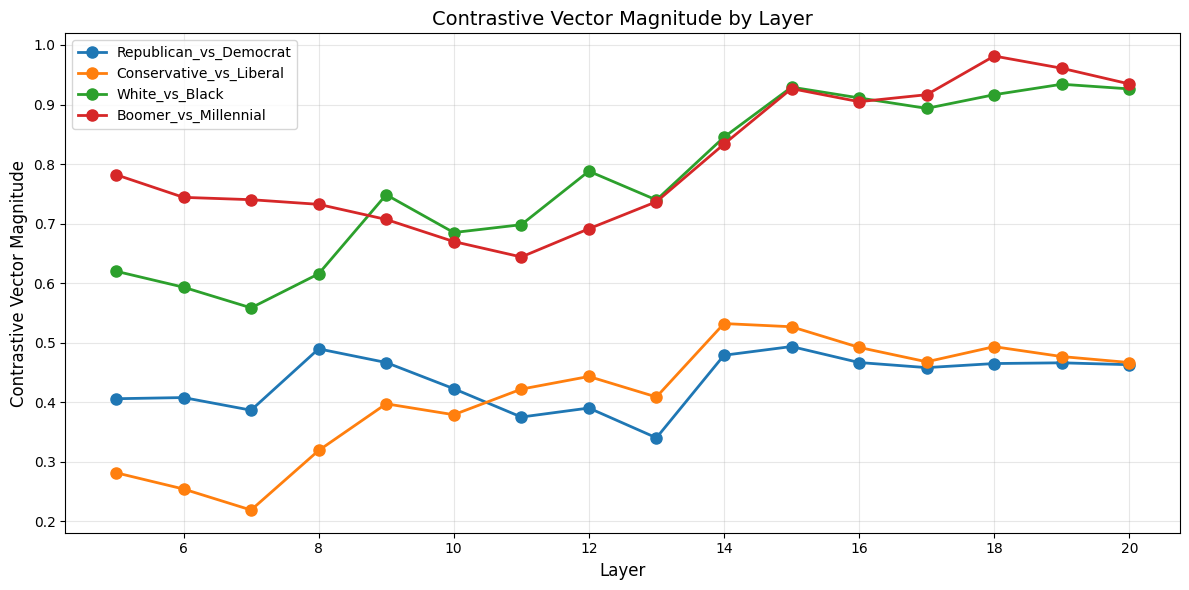

In [8]:
# Visualize contrastive vector magnitudes across layers
magnitude_data = []
for layer in sorted(all_contrastive_vectors.keys()):
    for name, data in all_contrastive_vectors[layer].items():
        magnitude_data.append({
            'layer': layer,
            'contrastive_pair': name,
            'magnitude': data['magnitude']
        })

mag_df = pd.DataFrame(magnitude_data)

plt.figure(figsize=(12, 6))
for pair_name in mag_df['contrastive_pair'].unique():
    subset = mag_df[mag_df['contrastive_pair'] == pair_name]
    plt.plot(subset['layer'], subset['magnitude'], 'o-', label=pair_name, linewidth=2, markersize=8)

plt.xlabel('Layer', fontsize=12)
plt.ylabel('Contrastive Vector Magnitude', fontsize=12)
plt.title('Contrastive Vector Magnitude by Layer', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Load Model for Steering Experiments

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Model loaded successfully.")

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded successfully.


## 4. Steering Functions

In [10]:
def get_activations_with_steering(model, tokenizer, text, layer_idx, steering_vector=None, strength=0.0):
    """
    Get hidden state activations with optional steering vector injection.

    Args:
        model: The LLM model
        tokenizer: Tokenizer
        text: Input text
        layer_idx: Which layer to extract/inject
        steering_vector: Optional steering vector to inject
        strength: Injection strength multiplier

    Returns:
        Hidden state at the last token position
    """
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # Apply steering if provided
        if steering_vector is not None and strength != 0.0:
            steer = steering_vector.to(h_states.device).to(h_states.dtype)
            # Add steering vector to all token positions
            h_states = h_states + strength * steer.unsqueeze(0).unsqueeze(0)

        if h_states.dim() == 3:
            captured_hidden = h_states[0, -1, :].detach().cpu()
        elif h_states.dim() == 2:
            captured_hidden = h_states[-1, :].detach().cpu()

        # Return modified output if steering was applied
        if steering_vector is not None and strength != 0.0:
            if isinstance(output, tuple):
                return (h_states,) + output[1:]
            return h_states
        return output

    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

In [11]:
def measure_contrastive_steering_effect(model, tokenizer, layer_vectors, contrastive_vec_data,
                                         layer_idx, strength=2.0):
    """
    Measure how steering with a CONTRASTIVE vector affects similarities to all demographics.

    Args:
        layer_vectors: Dictionary of demographic vectors for this layer
        contrastive_vec_data: Dict with 'vector', 'positive_demo', 'negative_demo'
        layer_idx: Layer to inject steering vector
        strength: Steering strength

    Returns:
        DataFrame with baseline and steered similarities for each demographic
    """
    steering_vec = contrastive_vec_data['vector']

    # Test prompt (neutral)
    test_prompt = "[INST] You are a person living in the United States. What are your thoughts on current events? [/INST]"

    # Get baseline activation (no steering)
    baseline_act = get_activations_with_steering(
        model, tokenizer, test_prompt, layer_idx,
        steering_vector=None, strength=0.0
    )

    # Get steered activation
    steered_act = get_activations_with_steering(
        model, tokenizer, test_prompt, layer_idx,
        steering_vector=steering_vec, strength=strength
    )

    # Measure similarity to all demographic vectors
    results = []

    for label, data in layer_vectors.items():
        demo_vec = data['vector']

        # Baseline similarity
        baseline_sim = F.cosine_similarity(
            baseline_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        # Steered similarity
        steered_sim = F.cosine_similarity(
            steered_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        # Change
        delta = steered_sim - baseline_sim

        # Mark if this is the positive or negative demo
        role = 'neutral'
        if label == contrastive_vec_data['positive_demo']:
            role = 'positive'
        elif label == contrastive_vec_data['negative_demo']:
            role = 'negative'

        results.append({
            'demographic': label,
            'category': label.split('_')[0],
            'baseline_sim': baseline_sim,
            'steered_sim': steered_sim,
            'delta': delta,
            'role': role,
            'layer': layer_idx
        })

    return pd.DataFrame(results)

In [12]:
def measure_original_steering_effect(model, tokenizer, layer_vectors,
                                      steering_label, layer_idx, strength=2.0):
    """
    Measure how steering with ORIGINAL (non-contrastive) vector affects similarities.

    This is for comparison with contrastive steering.
    """
    steering_vec = layer_vectors[steering_label]['vector']

    test_prompt = "[INST] You are a person living in the United States. What are your thoughts on current events? [/INST]"

    baseline_act = get_activations_with_steering(
        model, tokenizer, test_prompt, layer_idx,
        steering_vector=None, strength=0.0
    )

    steered_act = get_activations_with_steering(
        model, tokenizer, test_prompt, layer_idx,
        steering_vector=steering_vec, strength=strength
    )

    results = []

    for label, data in layer_vectors.items():
        demo_vec = data['vector']

        baseline_sim = F.cosine_similarity(
            baseline_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        steered_sim = F.cosine_similarity(
            steered_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        delta = steered_sim - baseline_sim

        results.append({
            'demographic': label,
            'category': label.split('_')[0],
            'baseline_sim': baseline_sim,
            'steered_sim': steered_sim,
            'delta': delta,
            'layer': layer_idx
        })

    return pd.DataFrame(results)

## 5. Contrastive Steering Experiments

In [13]:
# Test contrastive steering: Republican vs Democrat
TEST_LAYER = 13  # Based on delta magnitude analysis
STRENGTH = 2.0
CONTRASTIVE_PAIR = "Republican_vs_Democrat"

print(f"Testing Contrastive Steering: {CONTRASTIVE_PAIR}")
print(f"Layer: {TEST_LAYER}, Strength: {STRENGTH}")

contrastive_results = measure_contrastive_steering_effect(
    model, tokenizer,
    all_layer_vectors[TEST_LAYER],
    all_contrastive_vectors[TEST_LAYER][CONTRASTIVE_PAIR],
    layer_idx=TEST_LAYER,
    strength=STRENGTH
)

# Sort by delta
contrastive_results = contrastive_results.sort_values('delta', ascending=False)

print("\n=== Top 10 Positive Deltas ===")
print(contrastive_results.head(10)[['demographic', 'delta', 'role']])

print("\n=== Top 10 Negative Deltas ===")
print(contrastive_results.tail(10)[['demographic', 'delta', 'role']])

Testing Contrastive Steering: Republican_vs_Democrat
Layer: 13, Strength: 2.0

=== Top 10 Positive Deltas ===
                                          demographic     delta      role
7                           PartyID_Strong Republican  0.018715  positive
11                                            Sex_man  0.018494   neutral
10                                 PartyID_Republican  0.017050   neutral
30       Generation_person from the Silent Generation  0.013794   neutral
9                                       PartyID_Other  0.012756   neutral
14  Degree_person with less than high school educa...  0.010132   neutral
1                                   Race_White person  0.008560   neutral
31                             Generation_Baby Boomer  0.007996   neutral
3              PartyID_Independent leaning Republican  0.006378   neutral
29                Generation_person from Generation X  0.005005   neutral

=== Top 10 Negative Deltas ===
                                          de

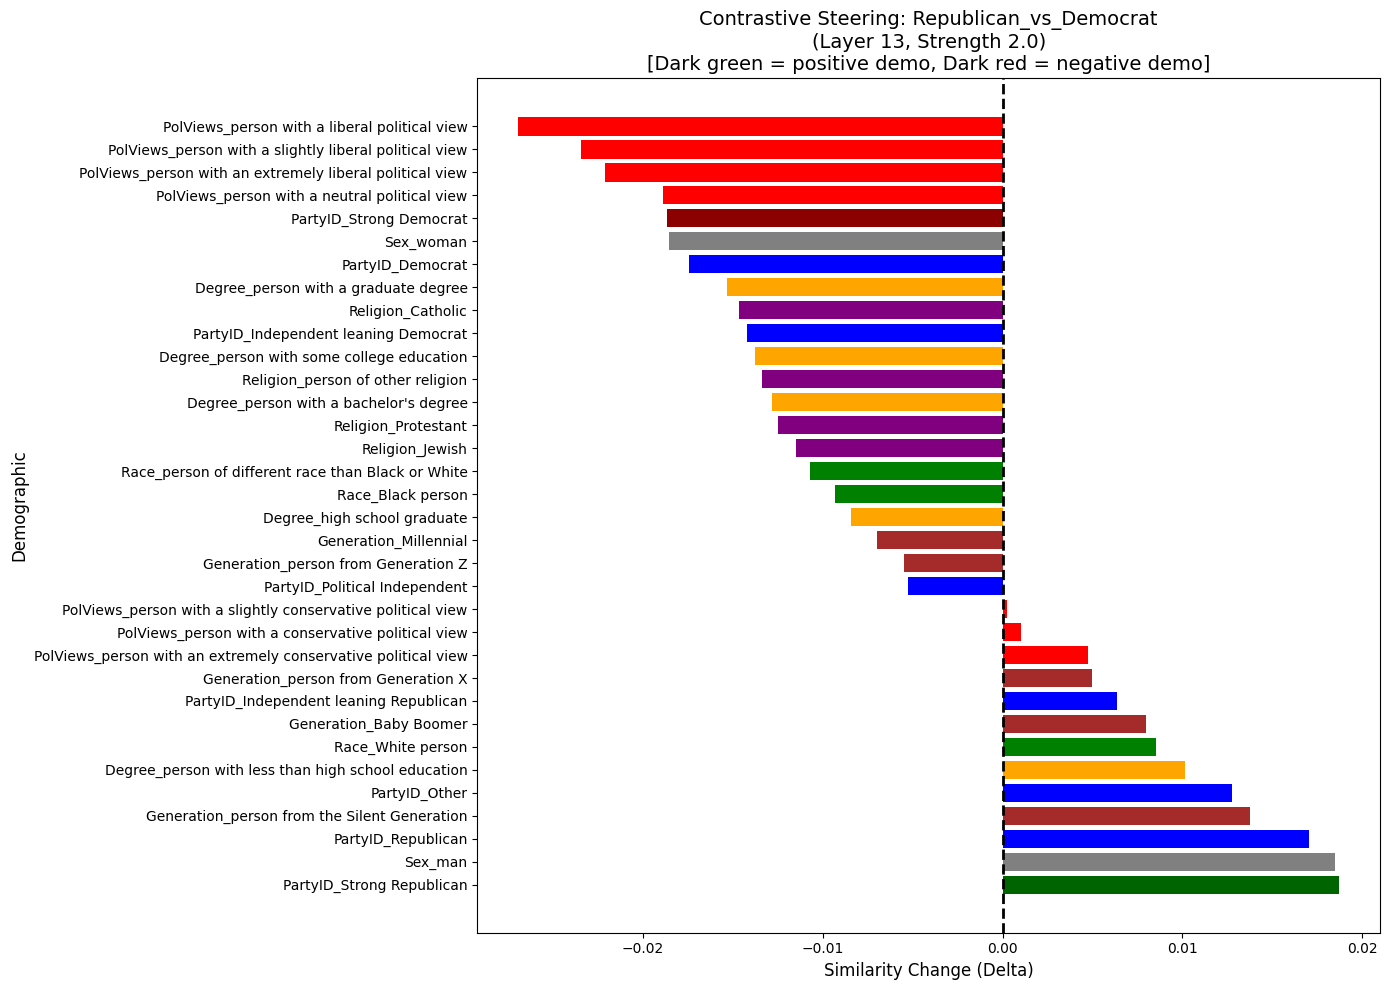


Demographics with positive delta: 13
Demographics with negative delta: 21


In [14]:
# Visualize contrastive steering effects
plt.figure(figsize=(14, 10))

# Color by role and category
def get_color(row):
    if row['role'] == 'positive':
        return 'darkgreen'
    elif row['role'] == 'negative':
        return 'darkred'
    else:
        category_colors = {
            'PartyID': 'blue',
            'PolViews': 'red',
            'Race': 'green',
            'Religion': 'purple',
            'Degree': 'orange',
            'Generation': 'brown',
            'Sex': 'gray'
        }
        return category_colors.get(row['category'], 'black')

colors = contrastive_results.apply(get_color, axis=1)

plt.barh(
    contrastive_results['demographic'],
    contrastive_results['delta'],
    color=colors
)

plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Similarity Change (Delta)', fontsize=12)
plt.ylabel('Demographic', fontsize=12)
plt.title(f'Contrastive Steering: {CONTRASTIVE_PAIR}\n(Layer {TEST_LAYER}, Strength {STRENGTH})\n[Dark green = positive demo, Dark red = negative demo]', fontsize=14)
plt.tight_layout()
plt.show()

# Count positive vs negative deltas
n_positive = (contrastive_results['delta'] > 0).sum()
n_negative = (contrastive_results['delta'] < 0).sum()
print(f"\nDemographics with positive delta: {n_positive}")
print(f"Demographics with negative delta: {n_negative}")

## 6. Compare Original vs Contrastive Steering

In [15]:
# Get original steering results for comparison
ORIGINAL_STEERING_DEMO = "PartyID_Strong Republican"

print(f"Comparing Original ({ORIGINAL_STEERING_DEMO}) vs Contrastive ({CONTRASTIVE_PAIR})")

original_results = measure_original_steering_effect(
    model, tokenizer,
    all_layer_vectors[TEST_LAYER],
    steering_label=ORIGINAL_STEERING_DEMO,
    layer_idx=TEST_LAYER,
    strength=STRENGTH
)

original_results = original_results.sort_values('delta', ascending=False)

Comparing Original (PartyID_Strong Republican) vs Contrastive (Republican_vs_Democrat)


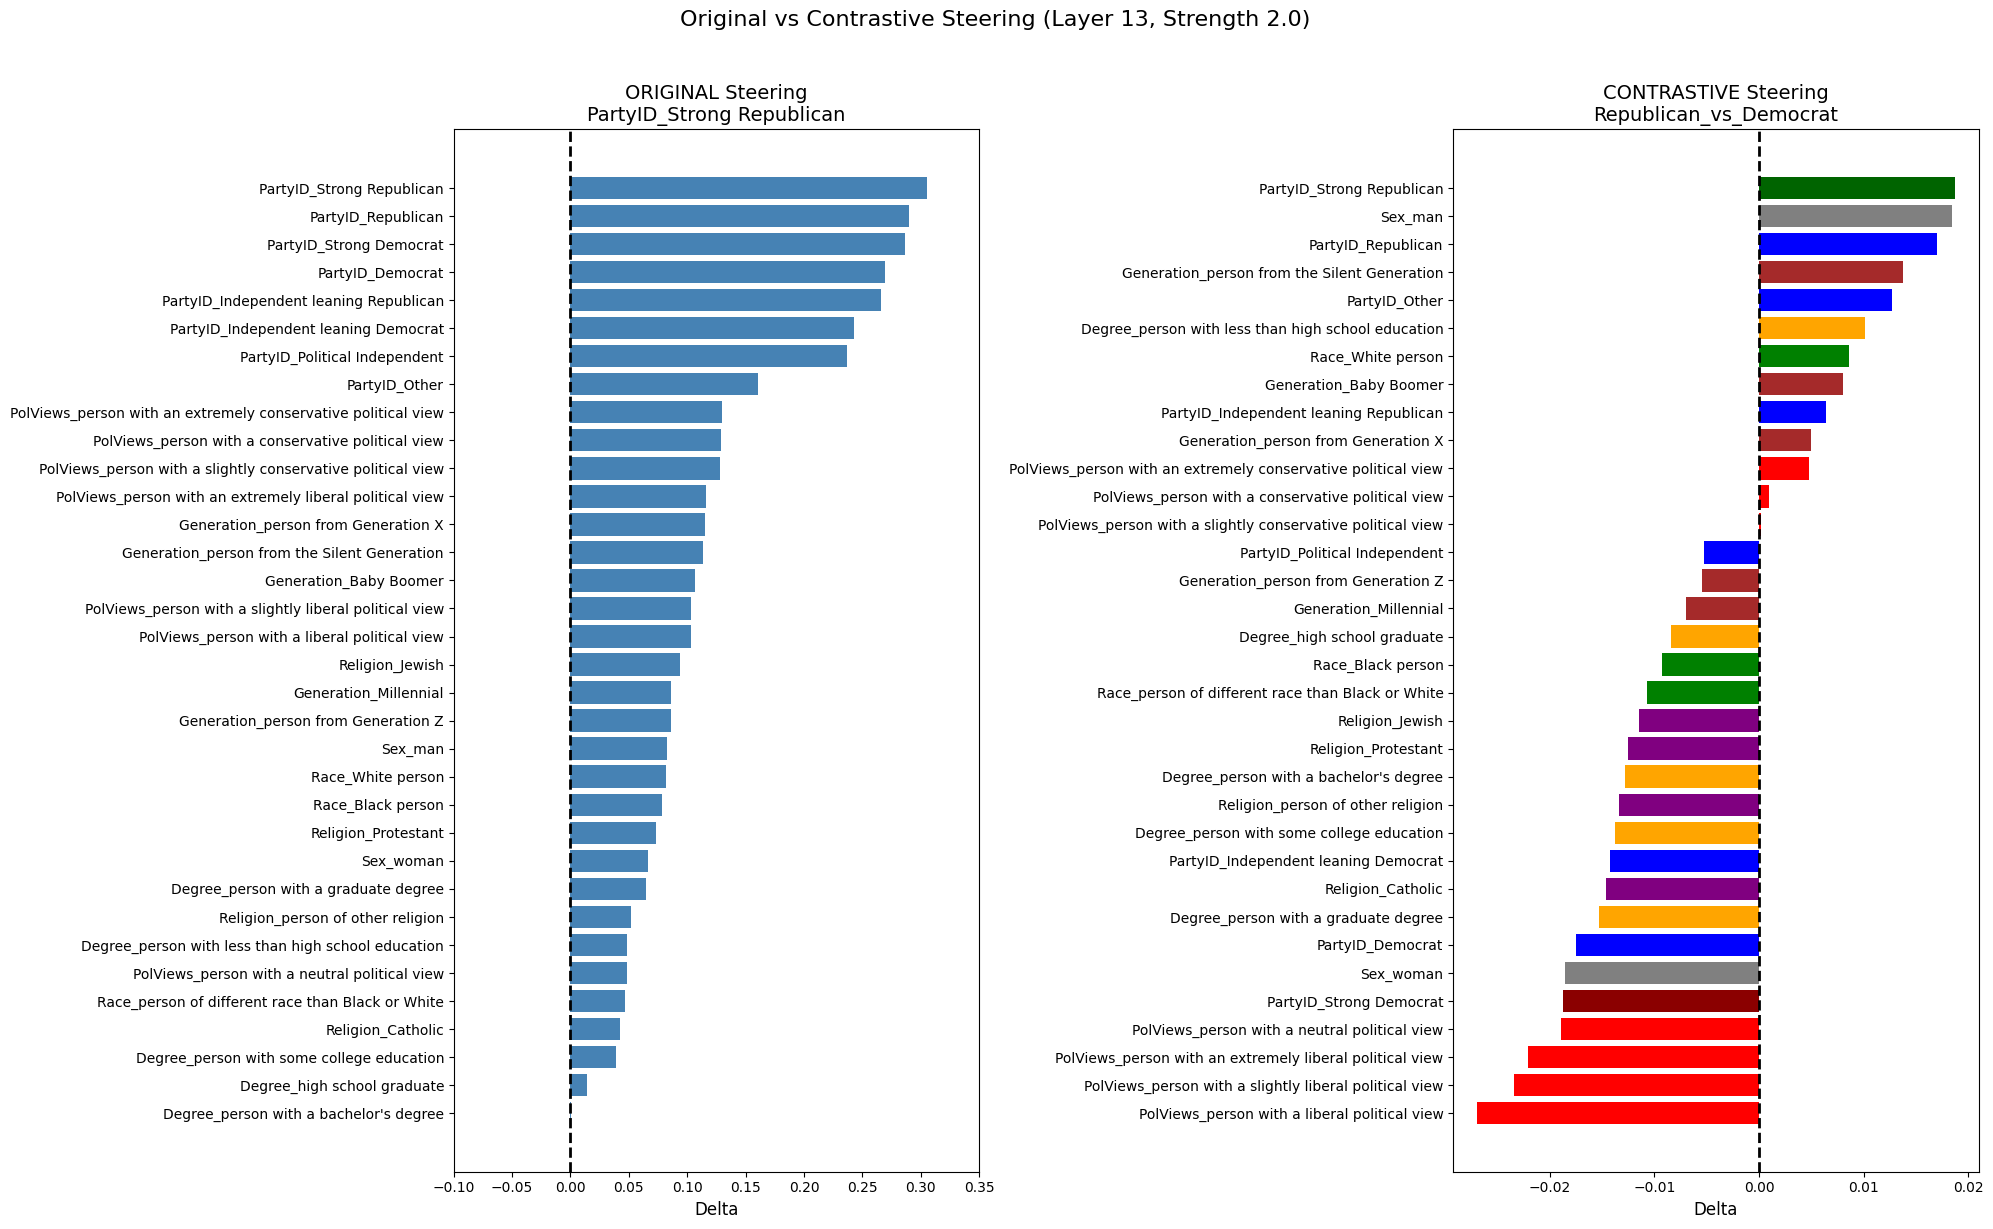


=== COMPARISON SUMMARY ===

Original Steering (PartyID_Strong Republican):
  Positive deltas: 34
  Negative deltas: 0
  Mean delta: 0.1207

Contrastive Steering (Republican_vs_Democrat):
  Positive deltas: 13
  Negative deltas: 21
  Mean delta: -0.0052


In [16]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Original steering
original_sorted = original_results.sort_values('delta', ascending=True)
axes[0].barh(
    original_sorted['demographic'],
    original_sorted['delta'],
    color='steelblue'
)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Delta', fontsize=12)
axes[0].set_title(f'ORIGINAL Steering\n{ORIGINAL_STEERING_DEMO}', fontsize=14)
axes[0].set_xlim(-0.1, max(original_sorted['delta'].max() * 1.1, 0.35))

# Contrastive steering
contrastive_sorted = contrastive_results.sort_values('delta', ascending=True)
colors = contrastive_sorted.apply(get_color, axis=1)
axes[1].barh(
    contrastive_sorted['demographic'],
    contrastive_sorted['delta'],
    color=colors
)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Delta', fontsize=12)
axes[1].set_title(f'CONTRASTIVE Steering\n{CONTRASTIVE_PAIR}', fontsize=14)

plt.suptitle(f'Original vs Contrastive Steering (Layer {TEST_LAYER}, Strength {STRENGTH})', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== COMPARISON SUMMARY ===")
print(f"\nOriginal Steering ({ORIGINAL_STEERING_DEMO}):")
print(f"  Positive deltas: {(original_results['delta'] > 0).sum()}")
print(f"  Negative deltas: {(original_results['delta'] < 0).sum()}")
print(f"  Mean delta: {original_results['delta'].mean():.4f}")

print(f"\nContrastive Steering ({CONTRASTIVE_PAIR}):")
print(f"  Positive deltas: {(contrastive_results['delta'] > 0).sum()}")
print(f"  Negative deltas: {(contrastive_results['delta'] < 0).sum()}")
print(f"  Mean delta: {contrastive_results['delta'].mean():.4f}")

In [17]:
# Merge for detailed comparison
comparison_df = original_results[['demographic', 'delta']].rename(columns={'delta': 'original_delta'})
comparison_df = comparison_df.merge(
    contrastive_results[['demographic', 'delta', 'role']].rename(columns={'delta': 'contrastive_delta'}),
    on='demographic'
)
comparison_df['delta_difference'] = comparison_df['contrastive_delta'] - comparison_df['original_delta']

print("Demographics where contrastive has MORE NEGATIVE delta than original:")
negative_shift = comparison_df[comparison_df['delta_difference'] < -0.05].sort_values('delta_difference')
print(negative_shift[['demographic', 'original_delta', 'contrastive_delta', 'delta_difference', 'role']])

Demographics where contrastive has MORE NEGATIVE delta than original:
                                          demographic  original_delta  \
2                             PartyID_Strong Democrat        0.286072   
3                                    PartyID_Democrat        0.269272   
0                           PartyID_Strong Republican        0.304909   
1                                  PartyID_Republican        0.289694   
4              PartyID_Independent leaning Republican        0.266037   
5                PartyID_Independent leaning Democrat        0.242798   
6                       PartyID_Political Independent        0.236862   
7                                       PartyID_Other        0.160156   
11  PolViews_person with an extremely liberal poli...        0.116150   
16      PolViews_person with a liberal political view        0.102890   
9   PolViews_person with a conservative political ...        0.129028   
10  PolViews_person with a slightly conservative p... 

## 7. Test All Contrastive Pairs

In [18]:
# Run all contrastive pairs at the test layer
all_contrastive_results = {}

for pair_name in all_contrastive_vectors[TEST_LAYER].keys():
    print(f"Testing: {pair_name}...")
    results = measure_contrastive_steering_effect(
        model, tokenizer,
        all_layer_vectors[TEST_LAYER],
        all_contrastive_vectors[TEST_LAYER][pair_name],
        layer_idx=TEST_LAYER,
        strength=STRENGTH
    )
    all_contrastive_results[pair_name] = results

print("\nDone!")

Testing: Republican_vs_Democrat...
Testing: Conservative_vs_Liberal...
Testing: White_vs_Black...
Testing: Boomer_vs_Millennial...

Done!


In [19]:
# Summary for each contrastive pair
summary_data = []

for pair_name, results_df in all_contrastive_results.items():
    pos_demo = all_contrastive_vectors[TEST_LAYER][pair_name]['positive_demo']
    neg_demo = all_contrastive_vectors[TEST_LAYER][pair_name]['negative_demo']

    pos_delta = results_df[results_df['demographic'] == pos_demo]['delta'].values[0]
    neg_delta = results_df[results_df['demographic'] == neg_demo]['delta'].values[0]

    n_positive = (results_df['delta'] > 0).sum()
    n_negative = (results_df['delta'] < 0).sum()

    summary_data.append({
        'pair': pair_name,
        'positive_demo': pos_demo,
        'negative_demo': neg_demo,
        'pos_demo_delta': pos_delta,
        'neg_demo_delta': neg_delta,
        'oppositional': pos_delta > 0 and neg_delta < 0,
        'n_positive_deltas': n_positive,
        'n_negative_deltas': n_negative
    })

summary_df = pd.DataFrame(summary_data)
print("=== Contrastive Steering Summary ===")
summary_df

=== Contrastive Steering Summary ===


,pair,positive_demo,negative_demo,pos_demo_delta,neg_demo_delta,oppositional,n_positive_deltas,n_negative_deltas
0,Republican_vs_Democrat,PartyID_Strong Republican,PartyID_Strong Democrat,0.018715,-0.018677,True,13,21
1,Conservative_vs_Liberal,PolViews_person with a conservative political ...,PolViews_person with a liberal political view,0.026871,-0.026962,True,19,15
2,White_vs_Black,Race_White person,Race_Black person,0.086731,-0.085236,True,13,21
3,Boomer_vs_Millennial,Generation_Baby Boomer,Generation_Millennial,0.087471,-0.083557,True,27,7


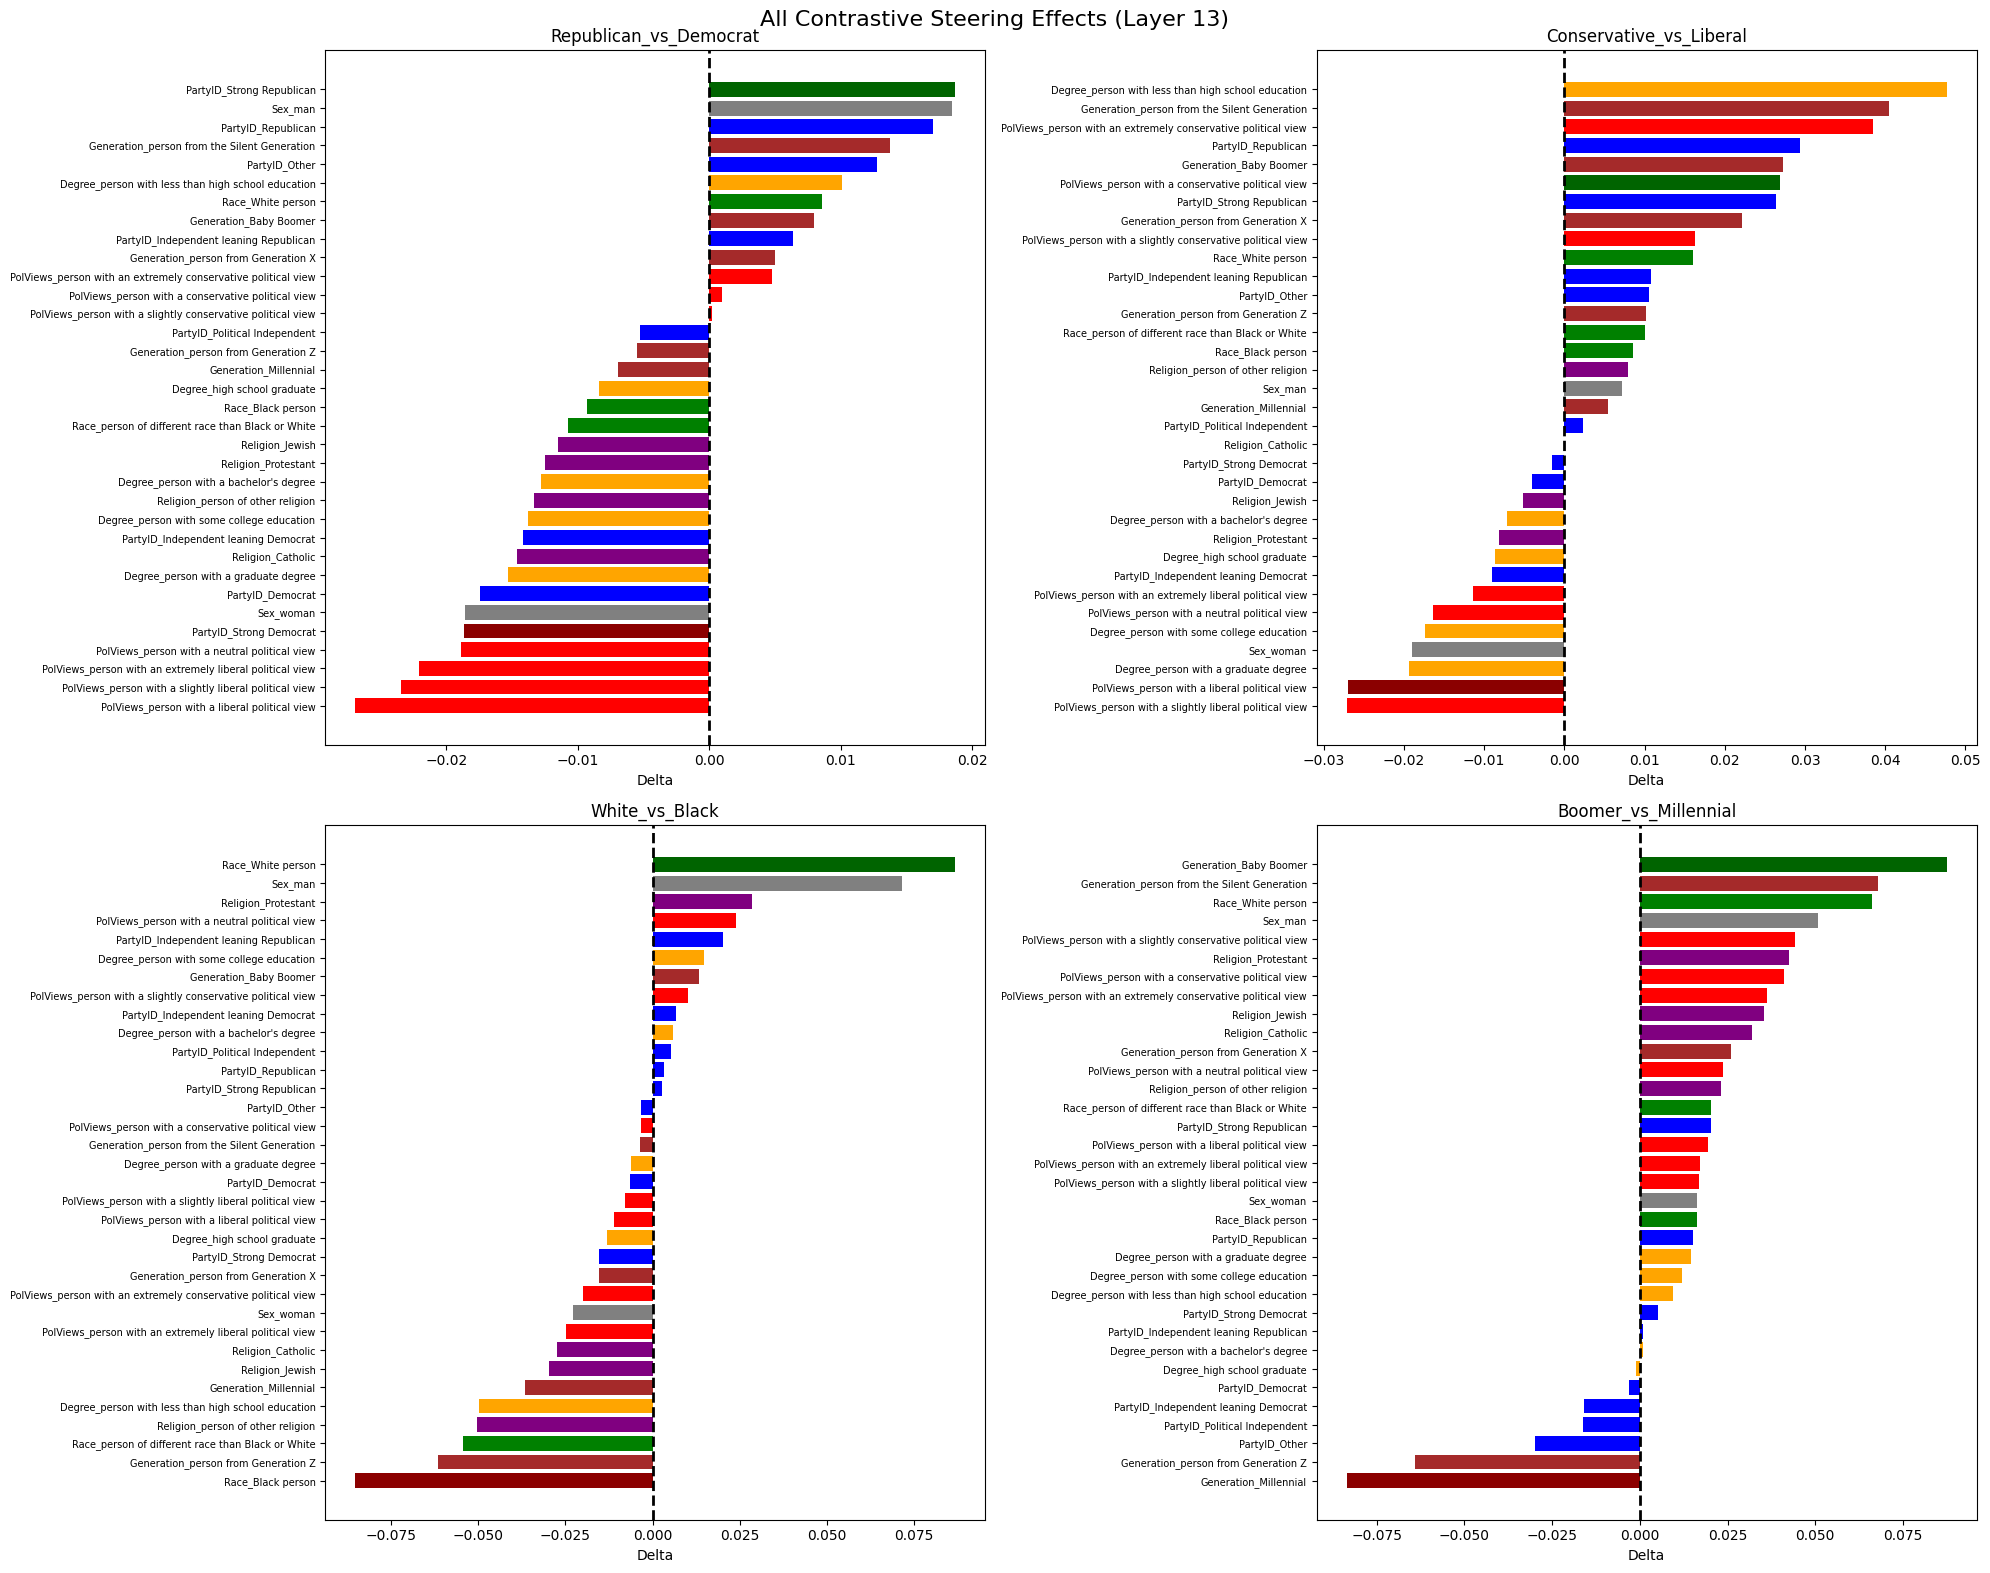

In [20]:
# Visualize all contrastive pairs
n_pairs = len(all_contrastive_results)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, (pair_name, results_df) in enumerate(all_contrastive_results.items()):
    if idx >= 4:
        break

    ax = axes[idx]
    results_sorted = results_df.sort_values('delta', ascending=True)

    colors = results_sorted.apply(get_color, axis=1)

    ax.barh(
        results_sorted['demographic'],
        results_sorted['delta'],
        color=colors
    )
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Delta', fontsize=10)
    ax.set_title(f'{pair_name}', fontsize=12)
    ax.tick_params(axis='y', labelsize=7)

plt.suptitle(f'All Contrastive Steering Effects (Layer {TEST_LAYER})', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Layer Comparison for Contrastive Steering

In [21]:
# Test which layer produces clearest oppositional effects
CONTRASTIVE_PAIR = "Republican_vs_Democrat"

layer_contrastive_results = []

for layer in all_contrastive_vectors.keys():
    print(f"Testing Layer {layer}...")

    results = measure_contrastive_steering_effect(
        model, tokenizer,
        all_layer_vectors[layer],
        all_contrastive_vectors[layer][CONTRASTIVE_PAIR],
        layer_idx=layer,
        strength=STRENGTH
    )

    pos_demo = all_contrastive_vectors[layer][CONTRASTIVE_PAIR]['positive_demo']
    neg_demo = all_contrastive_vectors[layer][CONTRASTIVE_PAIR]['negative_demo']

    pos_delta = results[results['demographic'] == pos_demo]['delta'].values[0]
    neg_delta = results[results['demographic'] == neg_demo]['delta'].values[0]

    n_positive = (results['delta'] > 0).sum()
    n_negative = (results['delta'] < 0).sum()

    layer_contrastive_results.append({
        'layer': layer,
        'pos_demo_delta': pos_delta,
        'neg_demo_delta': neg_delta,
        'oppositional_strength': pos_delta - neg_delta,  # Higher = more oppositional
        'n_positive_deltas': n_positive,
        'n_negative_deltas': n_negative,
        'balance': abs(n_positive - n_negative)  # Lower = more balanced
    })

layer_results_df = pd.DataFrame(layer_contrastive_results)
print("\nDone!")
layer_results_df

Testing Layer 5...
Testing Layer 6...
Testing Layer 7...
Testing Layer 8...
Testing Layer 9...
Testing Layer 10...
Testing Layer 11...
Testing Layer 12...
Testing Layer 13...
Testing Layer 14...
Testing Layer 15...
Testing Layer 16...
Testing Layer 17...
Testing Layer 18...
Testing Layer 19...
Testing Layer 20...

Done!


,layer,pos_demo_delta,neg_demo_delta,oppositional_strength,n_positive_deltas,n_negative_deltas,balance
0,5,0.050400,-0.048645,0.099045,18,16,2
1,6,0.046646,-0.047868,0.094514,23,11,12
2,7,0.040595,-0.040274,0.080868,18,16,2
3,8,0.056091,-0.056702,0.112793,14,20,6
4,9,0.046906,-0.046909,0.093815,12,22,10
5,10,0.035423,-0.035657,0.071080,10,24,14
6,11,0.027176,-0.027931,0.055107,13,21,8
7,12,0.026581,-0.026905,0.053486,13,21,8
8,13,0.018715,-0.018677,0.037392,13,21,8
9,14,0.033173,-0.034134,0.067307,14,20,6


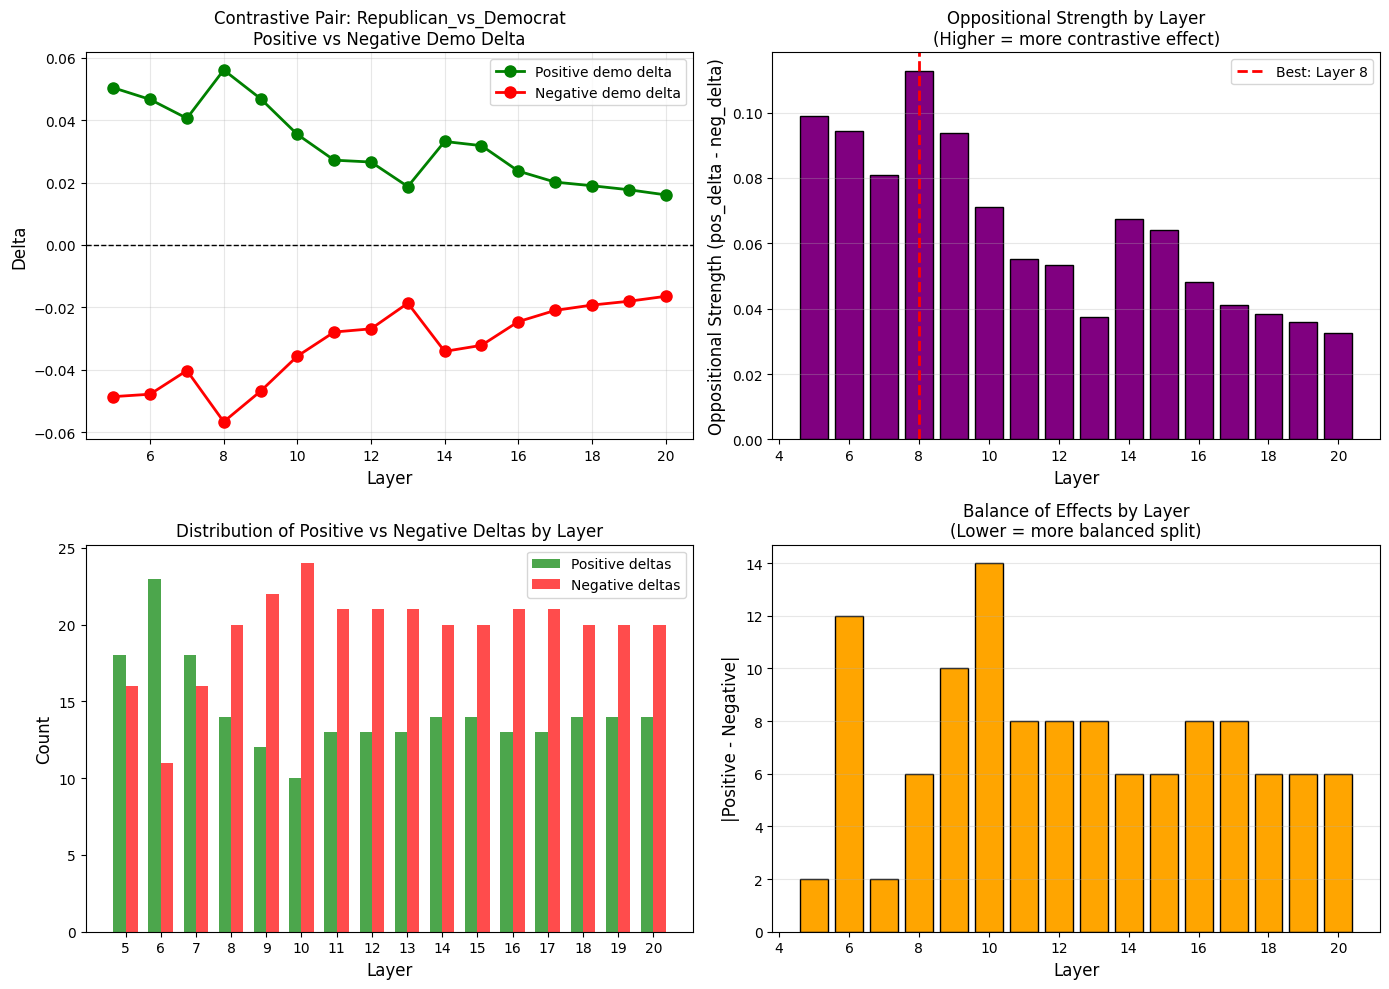


=== BEST LAYER ANALYSIS ===
Best layer by oppositional strength: Layer 8
  Positive demo delta: 0.0561
  Negative demo delta: -0.0567
  Oppositional strength: 0.1128


In [22]:
# Visualize layer comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Positive and negative demo deltas by layer
axes[0, 0].plot(layer_results_df['layer'], layer_results_df['pos_demo_delta'], 'g-o', label='Positive demo delta', linewidth=2, markersize=8)
axes[0, 0].plot(layer_results_df['layer'], layer_results_df['neg_demo_delta'], 'r-o', label='Negative demo delta', linewidth=2, markersize=8)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Layer', fontsize=12)
axes[0, 0].set_ylabel('Delta', fontsize=12)
axes[0, 0].set_title(f'Contrastive Pair: {CONTRASTIVE_PAIR}\nPositive vs Negative Demo Delta', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Oppositional strength by layer
axes[0, 1].bar(layer_results_df['layer'], layer_results_df['oppositional_strength'], color='purple', edgecolor='black')
axes[0, 1].set_xlabel('Layer', fontsize=12)
axes[0, 1].set_ylabel('Oppositional Strength (pos_delta - neg_delta)', fontsize=12)
axes[0, 1].set_title('Oppositional Strength by Layer\n(Higher = more contrastive effect)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Highlight best layer
best_layer = layer_results_df.loc[layer_results_df['oppositional_strength'].idxmax(), 'layer']
axes[0, 1].axvline(x=best_layer, color='red', linestyle='--', linewidth=2, label=f'Best: Layer {best_layer}')
axes[0, 1].legend()

# Plot 3: Number of positive vs negative deltas
width = 0.35
x = np.array(layer_results_df['layer'])
axes[1, 0].bar(x - width/2, layer_results_df['n_positive_deltas'], width, label='Positive deltas', color='green', alpha=0.7)
axes[1, 0].bar(x + width/2, layer_results_df['n_negative_deltas'], width, label='Negative deltas', color='red', alpha=0.7)
axes[1, 0].set_xlabel('Layer', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Distribution of Positive vs Negative Deltas by Layer', fontsize=12)
axes[1, 0].legend()
axes[1, 0].set_xticks(x)

# Plot 4: Balance (lower = more balanced distribution)
axes[1, 1].bar(layer_results_df['layer'], layer_results_df['balance'], color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Layer', fontsize=12)
axes[1, 1].set_ylabel('|Positive - Negative|', fontsize=12)
axes[1, 1].set_title('Balance of Effects by Layer\n(Lower = more balanced split)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n=== BEST LAYER ANALYSIS ===")
print(f"Best layer by oppositional strength: Layer {best_layer}")
best_row = layer_results_df[layer_results_df['layer'] == best_layer].iloc[0]
print(f"  Positive demo delta: {best_row['pos_demo_delta']:.4f}")
print(f"  Negative demo delta: {best_row['neg_demo_delta']:.4f}")
print(f"  Oppositional strength: {best_row['oppositional_strength']:.4f}")

## 9. Save Results

In [23]:
# Save contrastive steering results for all pairs at test layer
all_results_combined = []
for pair_name, results_df in all_contrastive_results.items():
    results_df = results_df.copy()
    results_df['contrastive_pair'] = pair_name
    all_results_combined.append(results_df)

combined_df = pd.concat(all_results_combined, ignore_index=True)
combined_df.to_csv(os.path.join(BASE_DIR, f"contrastive_steering_results_layer{TEST_LAYER}.csv"), index=False)

# Save layer comparison results
layer_results_df.to_csv(os.path.join(BASE_DIR, "contrastive_layer_comparison.csv"), index=False)

# Save comparison between original and contrastive
comparison_df.to_csv(os.path.join(BASE_DIR, f"contrastive_vs_original_comparison_layer{TEST_LAYER}.csv"), index=False)

# Save summary
summary_df.to_csv(os.path.join(BASE_DIR, f"contrastive_steering_summary_layer{TEST_LAYER}.csv"), index=False)

print("Results saved:")
print(f"  - contrastive_steering_results_layer{TEST_LAYER}.csv")
print(f"  - contrastive_layer_comparison.csv")
print(f"  - contrastive_vs_original_comparison_layer{TEST_LAYER}.csv")
print(f"  - contrastive_steering_summary_layer{TEST_LAYER}.csv")

Results saved:
  - contrastive_steering_results_layer13.csv
  - contrastive_layer_comparison.csv
  - contrastive_vs_original_comparison_layer13.csv
  - contrastive_steering_summary_layer13.csv


## 10. Response Generation with Contrastive Steering

**Goal:** Test whether contrastive steering actually changes LLM responses on policy questions.

**Approach:**
1. Binary choice probability: Ask A/B questions and measure probability shifts
2. Open-ended generation: Generate text responses with different steering strengths

**Expected Result:**
- Republican-Democrat contrastive vector should shift abortion stance toward Pro-Life
- Negative strength should shift toward Pro-Choice

In [24]:
# Define policy questions for testing (aligned with GSS survey topics)
# These 4 topics are addressed in the General Social Survey for comparison
POLICY_QUESTIONS = {
    "abortion": {
        "prompt": "[INST] What is your stance on abortion? Please answer in one sentence. [/INST]",
        "binary_prompt": "[INST] What is your stance on abortion? [/INST]\n(A) Pro-choice (woman should have the right to choose)\n(B) Pro-life (abortion should be restricted or banned)\nAnswer:",
        "expected_rep": "Pro-life (B)",
        "expected_dem": "Pro-choice (A)",
        "gss_variable": "ABANY"
    },
    "same_sex_marriage": {
        "prompt": "[INST] What is your stance on same-sex marriage? Please answer in one sentence. [/INST]",
        "binary_prompt": "[INST] What is your stance on same-sex marriage? [/INST]\n(A) Support (same-sex couples should have the right to marry)\n(B) Oppose (marriage should be between a man and a woman)\nAnswer:",
        "expected_rep": "Oppose (B)",
        "expected_dem": "Support (A)",
        "gss_variable": "MARSAME1"
    },
    "gun_control": {
        "prompt": "[INST] What is your stance on gun control? Please answer in one sentence. [/INST]",
        "binary_prompt": "[INST] What is your stance on gun control? [/INST]\n(A) Support stricter gun control laws\n(B) Protect Second Amendment gun rights\nAnswer:",
        "expected_rep": "Protect 2A (B)",
        "expected_dem": "Stricter control (A)",
        "gss_variable": "GUNLAW"
    },
    "death_penalty": {
        "prompt": "[INST] What is your stance on the death penalty? Please answer in one sentence. [/INST]",
        "binary_prompt": "[INST] What is your stance on the death penalty for persons convicted of murder? [/INST]\n(A) Oppose the death penalty\n(B) Favor the death penalty\nAnswer:",
        "expected_rep": "Favor (B)",
        "expected_dem": "Oppose (A)",
        "gss_variable": "CAPPUN"
    }
}

print(f"Defined {len(POLICY_QUESTIONS)} policy questions aligned with GSS survey topics:")
for topic, config in POLICY_QUESTIONS.items():
    print(f"  - {topic}: GSS variable = {config['gss_variable']}")

Defined 4 policy questions aligned with GSS survey topics:
  - abortion: GSS variable = ABANY
  - same_sex_marriage: GSS variable = MARSAME1
  - gun_control: GSS variable = GUNLAW
  - death_penalty: GSS variable = CAPPUN


In [25]:
def generate_with_steering(prompt, steering_vector, strength, layer_idx):
    """
    Generate text while adding (strength * steering_vector) to hidden states.

    Args:
        prompt: Input prompt
        steering_vector: Vector to inject
        strength: Injection strength (positive or negative)
        layer_idx: Layer to inject at

    Returns:
        Generated response text
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Prepare steering vector
    steer_vec = steering_vector.to(model.device).to(model.dtype)

    def steering_hook(module, input, output):
        perturbation = steer_vec.view(1, 1, -1) * strength

        if isinstance(output, tuple):
            modified_hidden = output[0] + perturbation
            return (modified_hidden,) + output[1:]
        elif isinstance(output, torch.Tensor):
            return output + perturbation
        else:
            return output

    # Register hook
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(steering_hook)

    # Generate
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=80,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
    finally:
        handle.remove()

    # Decode
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract just the response part
    response = full_text.split("[/INST]")[-1].strip()
    return response


def get_binary_choice_prob(prompt, steering_vector, strength, layer_idx):
    """
    Get probability of choosing option A vs B with steering applied.

    Returns:
        Probability of option A (first option)
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Prepare steering vector
    steer_vec = steering_vector.to(model.device).to(model.dtype)

    def steering_hook(module, input, output):
        perturbation = steer_vec.view(1, 1, -1) * strength

        if isinstance(output, tuple):
            modified_hidden = output[0] + perturbation
            return (modified_hidden,) + output[1:]
        elif isinstance(output, torch.Tensor):
            return output + perturbation
        else:
            return output

    # Register hook
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(steering_hook)

    # Forward pass
    try:
        with torch.no_grad():
            outputs = model(**inputs)
    finally:
        handle.remove()

    # Get logits for next token
    next_token_logits = outputs.logits[0, -1, :]

    # Get token IDs for A and B (with space prefix for Llama tokenization)
    id_a = tokenizer.encode(" A", add_special_tokens=False)[-1]
    id_b = tokenizer.encode(" B", add_special_tokens=False)[-1]

    # Compute probabilities
    probs = F.softmax(torch.tensor([next_token_logits[id_a], next_token_logits[id_b]]), dim=0)

    return probs[0].item()  # Probability of A

print("Generation functions defined.")

Generation functions defined.


### 10.1 Open-Ended Generation Test

Generate responses on abortion with different contrastive steering strengths.

In [26]:
# Test open-ended generation with contrastive steering
# Using Layer 8 (best oppositional strength from earlier analysis)
GENERATION_LAYER = 8
CONTRASTIVE_PAIR = "Republican_vs_Democrat"
contrastive_vec = all_contrastive_vectors[GENERATION_LAYER][CONTRASTIVE_PAIR]['vector']

# Test on abortion with topic-anchored prompt
# Note: Open-ended generation with party steering can cause topic drift
# Using more specific prompt to keep model on-topic
abortion_prompt = POLICY_QUESTIONS["abortion"]["prompt"]
strengths = [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]

print(f"=== OPEN-ENDED GENERATION: {CONTRASTIVE_PAIR} ===")
print(f"Layer: {GENERATION_LAYER}")
print(f"Prompt: {abortion_prompt}")
print("\nNote: Strong steering may cause topic drift in open-ended generation.")
print("Binary choice format (Section 10.2+) provides more reliable results.\n")

generation_results = []

for strength in strengths:
    response = generate_with_steering(abortion_prompt, contrastive_vec, strength, GENERATION_LAYER)
    print(f"Strength {strength:+.1f}: {response[:150]}...")
    print()

    generation_results.append({
        'strength': strength,
        'response': response
    })

gen_df = pd.DataFrame(generation_results)


### 10.2 Binary Choice Probability Test

Measure probability shift for Pro-choice (A) vs Pro-life (B) with different steering strengths.

**Expected:**
- Positive strength (toward Republican) → Lower P(Pro-choice), Higher P(Pro-life)
- Negative strength (toward Democrat) → Higher P(Pro-choice), Lower P(Pro-life)

In [27]:
# Binary choice probability test on abortion
binary_prompt = POLICY_QUESTIONS["abortion"]["binary_prompt"]
strengths = [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]

print(f"=== BINARY CHOICE PROBABILITY: {CONTRASTIVE_PAIR} ===")
print(f"Layer: {GENERATION_LAYER}")
print(f"Question: Abortion stance")
print(f"(A) Pro-choice | (B) Pro-life\n")

prob_results = []

for strength in strengths:
    prob_a = get_binary_choice_prob(binary_prompt, contrastive_vec, strength, GENERATION_LAYER)
    prob_b = 1.0 - prob_a

    print(f"Strength {strength:+.1f} → P(Pro-choice): {prob_a:.1%} | P(Pro-life): {prob_b:.1%}")

    prob_results.append({
        'strength': strength,
        'prob_prochoice': prob_a,
        'prob_prolife': prob_b
    })

prob_df = pd.DataFrame(prob_results)

=== BINARY CHOICE PROBABILITY: Republican_vs_Democrat ===
Layer: 8
Question: Abortion stance
(A) Pro-choice | (B) Pro-life

Strength -3.0 → P(Pro-choice): 91.9% | P(Pro-life): 8.1%
Strength -2.0 → P(Pro-choice): 88.0% | P(Pro-life): 12.0%
Strength -1.0 → P(Pro-choice): 82.8% | P(Pro-life): 17.2%
Strength +0.0 → P(Pro-choice): 75.9% | P(Pro-life): 24.1%
Strength +1.0 → P(Pro-choice): 67.2% | P(Pro-life): 32.8%
Strength +2.0 → P(Pro-choice): 55.5% | P(Pro-life): 44.5%
Strength +3.0 → P(Pro-choice): 44.9% | P(Pro-life): 55.1%


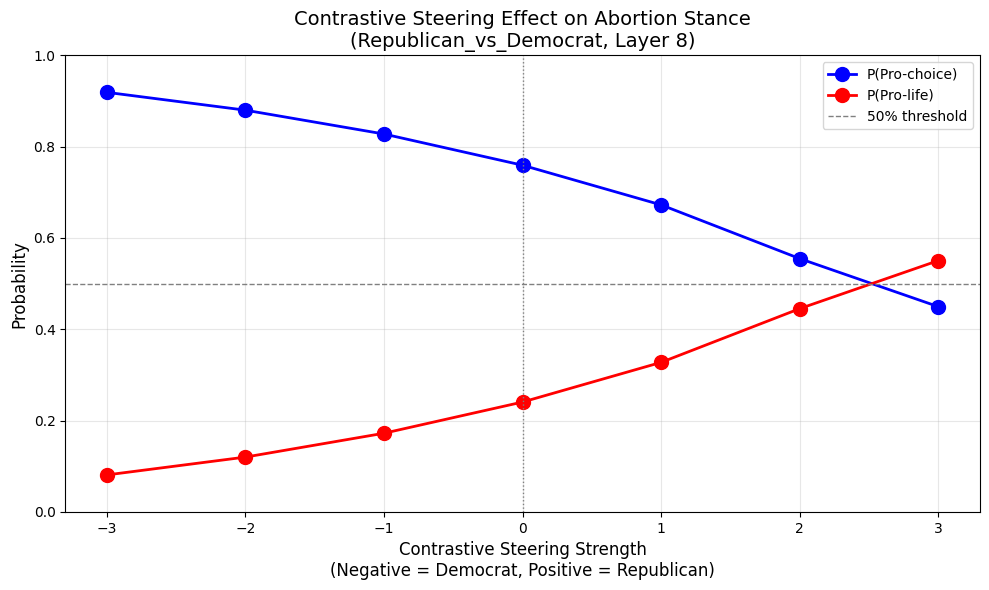


=== ANALYSIS ===
Baseline P(Pro-choice): 75.9%
At +3.0 (Republican): 44.9% (Δ = -31.0%)
At -3.0 (Democrat): 91.9% (Δ = +16.0%)

✓ Expected pattern confirmed: Republican steering decreases Pro-choice, Democrat steering increases it.


In [28]:
# Visualize probability shift
plt.figure(figsize=(10, 6))
plt.plot(prob_df['strength'], prob_df['prob_prochoice'], 'b-o', linewidth=2, markersize=10, label='P(Pro-choice)')
plt.plot(prob_df['strength'], prob_df['prob_prolife'], 'r-o', linewidth=2, markersize=10, label='P(Pro-life)')

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='50% threshold')
plt.axvline(x=0, color='gray', linestyle=':', linewidth=1)

plt.xlabel('Contrastive Steering Strength\n(Negative = Democrat, Positive = Republican)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title(f'Contrastive Steering Effect on Abortion Stance\n({CONTRASTIVE_PAIR}, Layer {GENERATION_LAYER})', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Check if the curve shows expected pattern
baseline_prob = prob_df[prob_df['strength'] == 0]['prob_prochoice'].values[0]
max_rep_prob = prob_df[prob_df['strength'] == 3.0]['prob_prochoice'].values[0]
max_dem_prob = prob_df[prob_df['strength'] == -3.0]['prob_prochoice'].values[0]

print(f"\n=== ANALYSIS ===")
print(f"Baseline P(Pro-choice): {baseline_prob:.1%}")
print(f"At +3.0 (Republican): {max_rep_prob:.1%} (Δ = {max_rep_prob - baseline_prob:+.1%})")
print(f"At -3.0 (Democrat): {max_dem_prob:.1%} (Δ = {max_dem_prob - baseline_prob:+.1%})")

if max_rep_prob < baseline_prob < max_dem_prob:
    print("\n✓ Expected pattern confirmed: Republican steering decreases Pro-choice, Democrat steering increases it.")
else:
    print("\n⚠ Pattern does not match expectations. May need different layer or strength.")

### 10.3 Test All GSS Policy Questions

Run the binary choice probability test on all 4 GSS-aligned policy questions:
- **Abortion** (ABANY)
- **Same-sex Marriage** (MARSAME1)
- **Gun Control** (GUNLAW)
- **Death Penalty** (CAPPUN)

These results can be compared with real-world GSS survey data to validate steering effectiveness.

In [29]:
# Test all policy questions
all_policy_results = []

for topic, config in POLICY_QUESTIONS.items():
    print(f"\nTesting: {topic.upper()}")
    print(f"  Expected Rep: {config['expected_rep']}, Expected Dem: {config['expected_dem']}")

    for strength in [-3.0, 0.0, 3.0]:
        prob_a = get_binary_choice_prob(config['binary_prompt'], contrastive_vec, strength, GENERATION_LAYER)

        all_policy_results.append({
            'topic': topic,
            'strength': strength,
            'prob_option_a': prob_a,
            'prob_option_b': 1 - prob_a
        })

        print(f"    Strength {strength:+.1f}: P(A)={prob_a:.1%}, P(B)={1-prob_a:.1%}")

all_policy_df = pd.DataFrame(all_policy_results)
print("\nDone!")


Testing: ABORTION
  Expected Rep: Pro-life (B), Expected Dem: Pro-choice (A)
    Strength -3.0: P(A)=91.9%, P(B)=8.1%
    Strength +0.0: P(A)=75.9%, P(B)=24.1%
    Strength +3.0: P(A)=44.9%, P(B)=55.1%

Testing: SAME_SEX_MARRIAGE
  Expected Rep: Oppose (B), Expected Dem: Support (A)
    Strength -3.0: P(A)=97.9%, P(B)=2.1%
    Strength +0.0: P(A)=90.5%, P(B)=9.5%
    Strength +3.0: P(A)=71.9%, P(B)=28.1%

Testing: GUN_CONTROL
  Expected Rep: Protect 2A (B), Expected Dem: Stricter control (A)
    Strength -3.0: P(A)=96.6%, P(B)=3.4%
    Strength +0.0: P(A)=58.9%, P(B)=41.1%
    Strength +3.0: P(A)=10.9%, P(B)=89.1%

Testing: DEATH_PENALTY
  Expected Rep: Favor (B), Expected Dem: Oppose (A)
    Strength -3.0: P(A)=86.4%, P(B)=13.6%
    Strength +0.0: P(A)=48.4%, P(B)=51.6%
    Strength +3.0: P(A)=12.6%, P(B)=87.4%

Done!


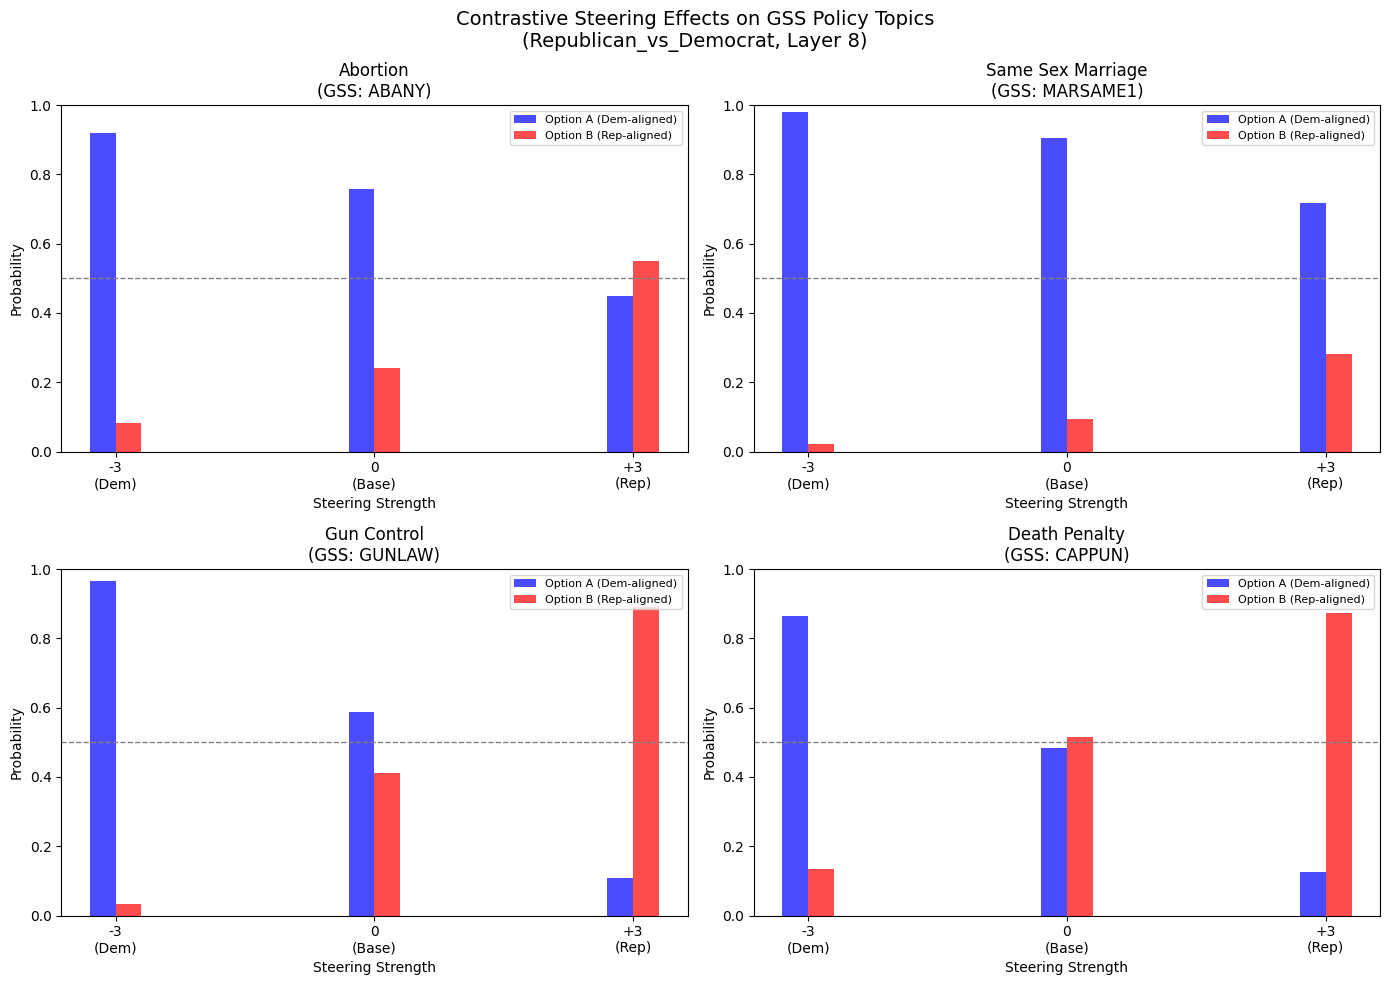

In [30]:
# Visualize all policy results (4 GSS-aligned topics)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

topics = list(POLICY_QUESTIONS.keys())

for idx, topic in enumerate(topics):
    ax = axes[idx]
    topic_data = all_policy_df[all_policy_df['topic'] == topic]

    ax.bar(topic_data['strength'] - 0.15, topic_data['prob_option_a'], width=0.3,
           label='Option A (Dem-aligned)', color='blue', alpha=0.7)
    ax.bar(topic_data['strength'] + 0.15, topic_data['prob_option_b'], width=0.3,
           label='Option B (Rep-aligned)', color='red', alpha=0.7)

    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel('Steering Strength')
    ax.set_ylabel('Probability')
    ax.set_title(f"{topic.replace('_', ' ').title()}\n(GSS: {POLICY_QUESTIONS[topic]['gss_variable']})")
    ax.set_xticks([-3, 0, 3])
    ax.set_xticklabels(['-3\n(Dem)', '0\n(Base)', '+3\n(Rep)'])
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle(f'Contrastive Steering Effects on GSS Policy Topics\n({CONTRASTIVE_PAIR}, Layer {GENERATION_LAYER})', fontsize=14)
plt.tight_layout()
plt.show()

### 10.4 Compare Original vs Contrastive Steering on Response Generation

Test whether contrastive steering produces clearer policy stance shifts than original steering.

In [31]:
# Compare original vs contrastive steering on abortion
original_vec = all_layer_vectors[GENERATION_LAYER]["PartyID_Strong Republican"]['vector']
contrastive_vec = all_contrastive_vectors[GENERATION_LAYER]["Republican_vs_Democrat"]['vector']

binary_prompt = POLICY_QUESTIONS["abortion"]["binary_prompt"]
strengths = [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]

original_probs = []
contrastive_probs = []

print("=== ORIGINAL vs CONTRASTIVE STEERING COMPARISON ===")
print("Topic: Abortion | (A) Pro-choice | (B) Pro-life\n")

print("Strength | Original P(A) | Contrastive P(A)")
print("-" * 45)

for strength in strengths:
    orig_prob = get_binary_choice_prob(binary_prompt, original_vec, strength, GENERATION_LAYER)
    cont_prob = get_binary_choice_prob(binary_prompt, contrastive_vec, strength, GENERATION_LAYER)

    original_probs.append(orig_prob)
    contrastive_probs.append(cont_prob)

    print(f"  {strength:+.1f}    |    {orig_prob:.1%}      |     {cont_prob:.1%}")

=== ORIGINAL vs CONTRASTIVE STEERING COMPARISON ===
Topic: Abortion | (A) Pro-choice | (B) Pro-life

Strength | Original P(A) | Contrastive P(A)
---------------------------------------------
  -3.0    |    82.1%      |     91.9%
  -2.0    |    73.9%      |     88.0%
  -1.0    |    73.6%      |     82.8%
  +0.0    |    75.9%      |     75.9%
  +1.0    |    71.9%      |     67.2%
  +2.0    |    66.2%      |     55.5%
  +3.0    |    69.3%      |     44.9%


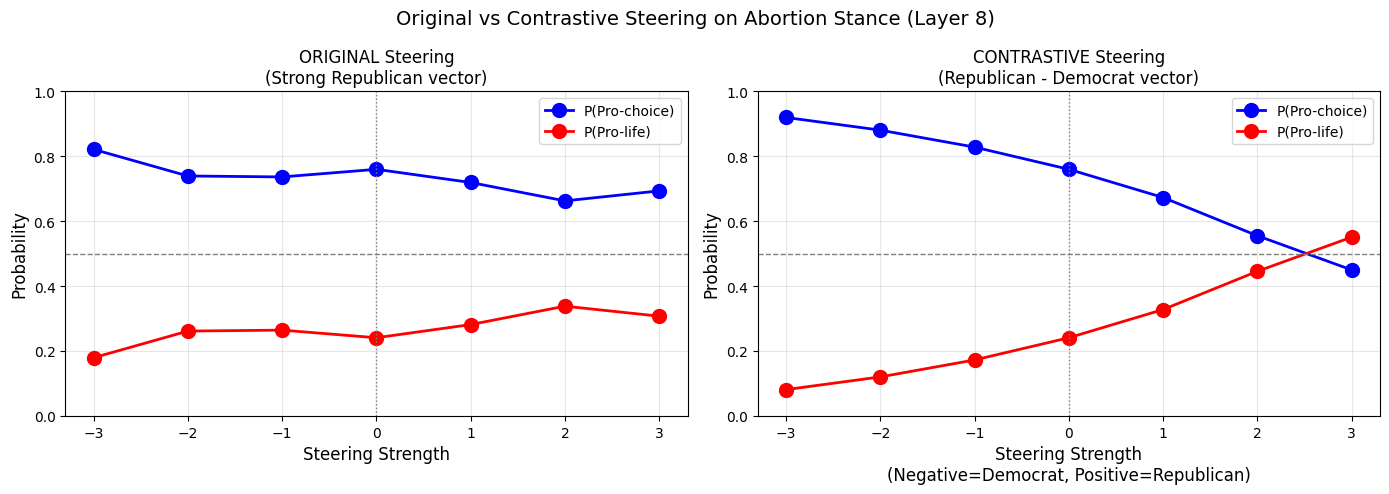


=== EFFECTIVENESS COMPARISON ===
Original steering range: 15.9%
Contrastive steering range: 46.9%

Contrastive steering is MORE effective at shifting stance.


In [32]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original steering
axes[0].plot(strengths, original_probs, 'b-o', linewidth=2, markersize=10, label='P(Pro-choice)')
axes[0].plot(strengths, [1-p for p in original_probs], 'r-o', linewidth=2, markersize=10, label='P(Pro-life)')
axes[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
axes[0].axvline(x=0, color='gray', linestyle=':', linewidth=1)
axes[0].set_xlabel('Steering Strength', fontsize=12)
axes[0].set_ylabel('Probability', fontsize=12)
axes[0].set_title('ORIGINAL Steering\n(Strong Republican vector)', fontsize=12)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)

# Contrastive steering
axes[1].plot(strengths, contrastive_probs, 'b-o', linewidth=2, markersize=10, label='P(Pro-choice)')
axes[1].plot(strengths, [1-p for p in contrastive_probs], 'r-o', linewidth=2, markersize=10, label='P(Pro-life)')
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(x=0, color='gray', linestyle=':', linewidth=1)
axes[1].set_xlabel('Steering Strength\n(Negative=Democrat, Positive=Republican)', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('CONTRASTIVE Steering\n(Republican - Democrat vector)', fontsize=12)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Original vs Contrastive Steering on Abortion Stance (Layer {GENERATION_LAYER})', fontsize=14)
plt.tight_layout()
plt.show()

# Analysis
orig_range = max(original_probs) - min(original_probs)
cont_range = max(contrastive_probs) - min(contrastive_probs)

print(f"\n=== EFFECTIVENESS COMPARISON ===")
print(f"Original steering range: {orig_range:.1%}")
print(f"Contrastive steering range: {cont_range:.1%}")
print(f"\nContrastive steering is {'MORE' if cont_range > orig_range else 'LESS'} effective at shifting stance.")

### 10.5 Save Response Generation Results

In [33]:
# Save response generation results
gen_df.to_csv(os.path.join(BASE_DIR, f"contrastive_generation_abortion_layer{GENERATION_LAYER}.csv"), index=False)
prob_df.to_csv(os.path.join(BASE_DIR, f"contrastive_abortion_probs_layer{GENERATION_LAYER}.csv"), index=False)
all_policy_df.to_csv(os.path.join(BASE_DIR, f"contrastive_all_policies_layer{GENERATION_LAYER}.csv"), index=False)

# Save comparison results
comparison_results = pd.DataFrame({
    'strength': strengths,
    'original_prob_prochoice': original_probs,
    'contrastive_prob_prochoice': contrastive_probs
})
comparison_results.to_csv(os.path.join(BASE_DIR, f"original_vs_contrastive_abortion_layer{GENERATION_LAYER}.csv"), index=False)

print("Response generation results saved:")
print(f"  - contrastive_generation_abortion_layer{GENERATION_LAYER}.csv")
print(f"  - contrastive_abortion_probs_layer{GENERATION_LAYER}.csv")
print(f"  - contrastive_all_policies_layer{GENERATION_LAYER}.csv")
print(f"  - original_vs_contrastive_abortion_layer{GENERATION_LAYER}.csv")

Response generation results saved:
  - contrastive_generation_abortion_layer8.csv
  - contrastive_abortion_probs_layer8.csv
  - contrastive_all_policies_layer8.csv
  - original_vs_contrastive_abortion_layer8.csv


### 10.6 Compare LLM Steering with Real-World GSS Data

**Goal:** Compare LLM steering results with real-world survey data from the General Social Survey (GSS) to:
1. Validate that steering produces realistic belief shifts
2. Find the optimal steering strength that matches real-world partisan differences

**Approach:**
1. Load GSS survey data with party affiliation
2. Compute real-world probability of each policy stance for Strong Republicans vs Strong Democrats
3. Compare with LLM steering results at different strengths
4. Find the strength that best matches real-world differences

In [34]:
# Load GSS data
# Expected path: data/gss_cleaned.csv or similar
GSS_DATA_PATH = os.path.join(BASE_DIR, "data/gss_cleaned.csv")

if os.path.exists(GSS_DATA_PATH):
    gss_df = pd.read_csv(GSS_DATA_PATH)
    print(f"Loaded GSS data: {len(gss_df)} rows")
    print(f"Columns: {list(gss_df.columns)}")
else:
    print(f"GSS data not found at {GSS_DATA_PATH}")
    print("Please ensure GSS data is available for comparison.")

Loaded GSS data: 20974 rows
Columns: ['year', 'partyid', 'PARTYID', 'sex', 'race', 'generation', 'degree', 'relig', 'polviews', 'ABANY', 'CAPPUN', 'GUNLAW', 'MARSAME1']


In [35]:
# Define GSS variable mappings for each policy topic
# Map GSS variable codes to binary categories matching our LLM prompts
GSS_MAPPINGS = {
    "abortion": {
        "variable": "ABANY",  # Abortion for any reason
        "option_a_values": [1],  # 1 = Yes (Pro-choice)
        "option_b_values": [2],  # 2 = No (Pro-life)
        "option_a_label": "Pro-choice",
        "option_b_label": "Pro-life"
    },
    "same_sex_marriage": {
        "variable": "MARSAME1",  # Same-sex couples should have right to marry
        "option_a_values": [1, 2],  # 1,2 = Strongly agree, Agree (Support)
        "option_b_values": [4, 5],  # 4,5 = Disagree, Strongly disagree (Oppose)
        "option_a_label": "Support",
        "option_b_label": "Oppose"
    },
    "gun_control": {
        "variable": "GUNLAW",  # Favor or oppose gun permits
        "option_a_values": [1],  # 1 = Favor (Stricter control)
        "option_b_values": [2],  # 2 = Oppose (Protect 2A)
        "option_a_label": "Stricter control",
        "option_b_label": "Protect 2A"
    },
    "death_penalty": {
        "variable": "CAPPUN",  # Favor or oppose death penalty
        "option_a_values": [2],  # 2 = Oppose
        "option_b_values": [1],  # 1 = Favor
        "option_a_label": "Oppose",
        "option_b_label": "Favor"
    }
}

# Expanded Party ID mapping with 5 categories
# GSS PARTYID: 0=Strong Dem, 1=Not strong Dem, 2=Ind near Dem, 3=Independent,
#              4=Ind near Rep, 5=Not strong Rep, 6=Strong Rep, 7=Other
PARTYID_MAPPING = {
    "Strong Democrat": 0,
    "Democrat": 1,          # Not very strong democrat
    "Independent": 3,       # Independent (neither)
    "Republican": 5,        # Not very strong republican
    "Strong Republican": 6
}

# Colors for visualization (Democrat blue to Republican red gradient)
PARTY_COLORS = {
    "Strong Democrat": "#0015BC",    # Dark blue
    "Democrat": "#6699FF",           # Light blue
    "Independent": "#808080",        # Gray
    "Republican": "#FF6666",         # Light red
    "Strong Republican": "#E81B23"   # Dark red
}

print("GSS variable mappings defined with 5 party categories:")
for party, code in PARTYID_MAPPING.items():
    print(f"  {party}: PARTYID = {code}")


GSS variable mappings defined with 5 party categories:
  Strong Democrat: PARTYID = 0
  Democrat: PARTYID = 1
  Independent: PARTYID = 3
  Republican: PARTYID = 5
  Strong Republican: PARTYID = 6


In [36]:
def compute_gss_probability(gss_df, topic, party_filter):
    """
    Compute probability of Option A for a given topic and party affiliation.

    Args:
        gss_df: GSS dataframe
        topic: Policy topic name
        party_filter: PARTYID value to filter by

    Returns:
        Probability of Option A, sample size
    """
    mapping = GSS_MAPPINGS[topic]
    var = mapping["variable"]

    # Check if variable exists
    if var not in gss_df.columns:
        return None, 0

    # Filter by party
    party_df = gss_df[gss_df["PARTYID"] == party_filter]

    # Get valid responses (Option A or B values only)
    valid_values = mapping["option_a_values"] + mapping["option_b_values"]
    valid_df = party_df[party_df[var].isin(valid_values)]

    if len(valid_df) == 0:
        return None, 0

    # Count Option A responses
    option_a_count = valid_df[var].isin(mapping["option_a_values"]).sum()
    prob_a = option_a_count / len(valid_df)

    return prob_a, len(valid_df)

# Compute real-world probabilities for each topic and party
if 'gss_df' in dir():
    print("=== REAL-WORLD GSS PROBABILITIES (5 Party Categories) ===\n")

    gss_probs = {}
    for topic in POLICY_QUESTIONS.keys():
        mapping = GSS_MAPPINGS[topic]
        gss_probs[topic] = {}

        print(f"{topic.upper()} ({mapping['variable']}):")
        print(f"  Option A = {mapping['option_a_label']}, Option B = {mapping['option_b_label']}")

        for party_name, party_code in PARTYID_MAPPING.items():
            prob, n = compute_gss_probability(gss_df, topic, party_code)
            gss_probs[topic][party_name] = {"prob_a": prob, "n": n}

            if prob is not None:
                print(f"  {party_name:18s}: P(A) = {prob:.1%} (n={n})")
            else:
                print(f"  {party_name:18s}: Variable not found")
        print()
else:
    print("GSS data not loaded. Skipping real-world comparison.")


=== REAL-WORLD GSS PROBABILITIES (5 Party Categories) ===

ABORTION (ABANY):
  Option A = Pro-choice, Option B = Pro-life
  Strong Democrat   : P(A) = 56.9% (n=1954)
  Democrat          : P(A) = 52.5% (n=1729)
  Independent       : P(A) = 41.5% (n=1813)
  Republican        : P(A) = 34.5% (n=1662)
  Strong Republican : P(A) = 22.0% (n=1574)

SAME_SEX_MARRIAGE (MARSAME1):
  Option A = Support, Option B = Oppose
  Strong Democrat   : P(A) = 58.2% (n=1317)
  Democrat          : P(A) = 63.1% (n=1228)
  Independent       : P(A) = 53.1% (n=1076)
  Republican        : P(A) = 43.1% (n=1127)
  Strong Republican : P(A) = 25.7% (n=944)

GUN_CONTROL (GUNLAW):
  Option A = Stricter control, Option B = Protect 2A
  Strong Democrat   : P(A) = 86.0% (n=2401)
  Democrat          : P(A) = 82.6% (n=2088)
  Independent       : P(A) = 73.0% (n=2294)
  Republican        : P(A) = 68.1% (n=1982)
  Strong Republican : P(A) = 51.9% (n=1995)

DEATH_PENALTY (CAPPUN):
  Option A = Oppose, Option B = Favor
  Strong 

In [37]:
# Run LLM steering with fine-grained strengths and compare with GSS
# Test strengths from -5 to +5 in increments of 0.5
FINE_STRENGTHS = np.arange(-5.0, 5.5, 0.5)

# Store results for comparison
llm_steering_results = {}

print("Running LLM steering with fine-grained strengths...")
print(f"Strengths: {list(FINE_STRENGTHS)}\n")

for topic in POLICY_QUESTIONS.keys():
    print(f"Testing: {topic}...")
    binary_prompt = POLICY_QUESTIONS[topic]["binary_prompt"]

    topic_results = []
    for strength in FINE_STRENGTHS:
        prob_a = get_binary_choice_prob(binary_prompt, contrastive_vec, strength, GENERATION_LAYER)
        topic_results.append({
            "strength": strength,
            "prob_a": prob_a
        })

    llm_steering_results[topic] = pd.DataFrame(topic_results)

print("\nDone!")

Running LLM steering with fine-grained strengths...
Strengths: [np.float64(-5.0), np.float64(-4.5), np.float64(-4.0), np.float64(-3.5), np.float64(-3.0), np.float64(-2.5), np.float64(-2.0), np.float64(-1.5), np.float64(-1.0), np.float64(-0.5), np.float64(0.0), np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]

Testing: abortion...
Testing: same_sex_marriage...
Testing: gun_control...
Testing: death_penalty...

Done!


In [38]:
# Find optimal steering strength that matches GSS probabilities
def find_optimal_strength(llm_results_df, target_prob):
    """Find the steering strength that produces probability closest to target."""
    if target_prob is None:
        return None, None

    errors = np.abs(llm_results_df["prob_a"].values - target_prob)
    best_idx = np.argmin(errors)
    best_strength = llm_results_df.iloc[best_idx]["strength"]
    best_error = errors[best_idx]

    return best_strength, best_error

# Compare LLM steering with GSS targets for all party categories
if 'gss_probs' in dir():
    print("=== OPTIMAL STEERING STRENGTH TO MATCH GSS (5 Parties) ===\n")

    optimal_results = []

    for topic in POLICY_QUESTIONS.keys():
        llm_df = llm_steering_results[topic]
        topic_gss = gss_probs[topic]

        print(f"{topic.upper()}:")

        result_row = {"topic": topic}

        for party_name in PARTYID_MAPPING.keys():
            party_data = topic_gss[party_name]
            target_prob = party_data["prob_a"]

            strength, error = find_optimal_strength(llm_df, target_prob)

            # Store in result row
            party_key = party_name.lower().replace(" ", "_")
            result_row[f"gss_{party_key}_prob_a"] = target_prob
            result_row[f"llm_strength_for_{party_key}"] = strength
            result_row[f"{party_key}_error"] = error

            if target_prob is not None:
                print(f"  {party_name:18s} (P(A)={target_prob:.1%}): strength = {strength:.1f} (error = {error:.3f})")

        optimal_results.append(result_row)
        print()

    optimal_df = pd.DataFrame(optimal_results)
else:
    print("GSS data not available. Skipping optimal strength analysis.")


=== OPTIMAL STEERING STRENGTH TO MATCH GSS (5 Parties) ===

ABORTION:
  Strong Democrat    (P(A)=56.9%): strength = 2.0 (error = 0.014)
  Democrat           (P(A)=52.5%): strength = 2.0 (error = 0.030)
  Independent        (P(A)=41.5%): strength = 3.5 (error = 0.015)
  Republican         (P(A)=34.5%): strength = 3.5 (error = 0.085)
  Strong Republican  (P(A)=22.0%): strength = 3.5 (error = 0.210)

SAME_SEX_MARRIAGE:
  Strong Democrat    (P(A)=58.2%): strength = 3.5 (error = 0.127)
  Democrat           (P(A)=63.1%): strength = 3.5 (error = 0.078)
  Independent        (P(A)=53.1%): strength = 3.5 (error = 0.178)
  Republican         (P(A)=43.1%): strength = 3.5 (error = 0.278)
  Strong Republican  (P(A)=25.7%): strength = 3.5 (error = 0.452)

GUN_CONTROL:
  Strong Democrat    (P(A)=86.0%): strength = -1.5 (error = 0.025)
  Democrat           (P(A)=82.6%): strength = -1.0 (error = 0.005)
  Independent        (P(A)=73.0%): strength = -0.5 (error = 0.010)
  Republican         (P(A)=68.1%): 

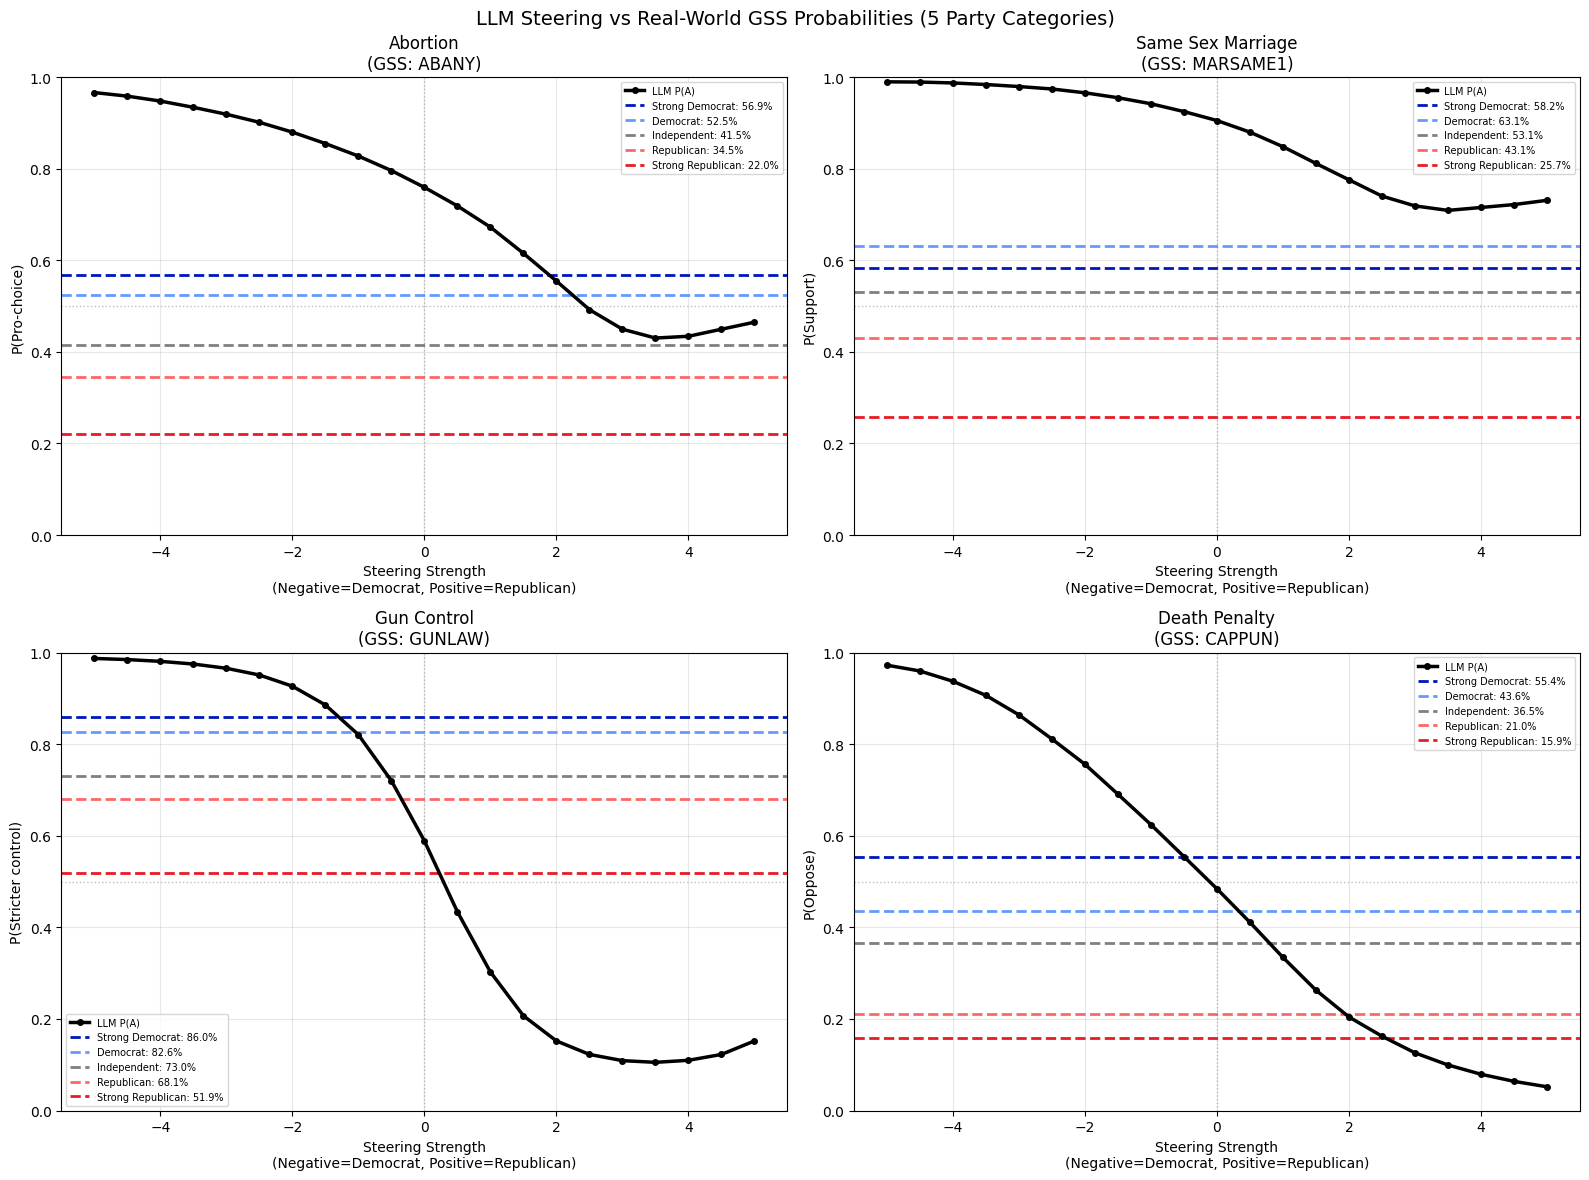

In [39]:
# Visualize LLM steering curves with GSS target lines for all parties
if 'gss_probs' in dir():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, topic in enumerate(POLICY_QUESTIONS.keys()):
        ax = axes[idx]
        llm_df = llm_steering_results[topic]
        topic_gss = gss_probs[topic]
        mapping = GSS_MAPPINGS[topic]

        # Plot LLM steering curve
        ax.plot(llm_df["strength"], llm_df["prob_a"], 'k-o', linewidth=2.5, markersize=4,
                label="LLM P(A)", zorder=10)

        # Add GSS target lines for each party
        for party_name, party_code in PARTYID_MAPPING.items():
            party_data = topic_gss[party_name]
            if party_data["prob_a"] is not None:
                color = PARTY_COLORS[party_name]
                ax.axhline(y=party_data["prob_a"], color=color, linestyle='--', linewidth=2,
                          label=f'{party_name}: {party_data["prob_a"]:.1%}')

        ax.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

        ax.set_xlabel("Steering Strength\n(Negative=Democrat, Positive=Republican)")
        ax.set_ylabel(f"P({mapping['option_a_label']})")
        ax.set_title(f"{topic.replace('_', ' ').title()}\n(GSS: {mapping['variable']})")
        ax.set_ylim(0, 1)
        ax.legend(loc='best', fontsize=7)
        ax.grid(True, alpha=0.3)

    plt.suptitle("LLM Steering vs Real-World GSS Probabilities (5 Party Categories)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("GSS data not available for visualization.")


In [40]:
# Save GSS comparison results
if 'optimal_df' in dir():
    optimal_df.to_csv(os.path.join(BASE_DIR, f"gss_comparison_optimal_strengths_layer{GENERATION_LAYER}.csv"), index=False)

    # Save all LLM steering results
    all_llm_results = []
    for topic, df in llm_steering_results.items():
        df_copy = df.copy()
        df_copy["topic"] = topic
        all_llm_results.append(df_copy)

    combined_llm_df = pd.concat(all_llm_results, ignore_index=True)
    combined_llm_df.to_csv(os.path.join(BASE_DIR, f"llm_steering_fine_grained_layer{GENERATION_LAYER}.csv"), index=False)

    print("GSS comparison results saved:")
    print(f"  - gss_comparison_optimal_strengths_layer{GENERATION_LAYER}.csv")
    print(f"  - llm_steering_fine_grained_layer{GENERATION_LAYER}.csv")
else:
    print("No GSS comparison results to save.")

GSS comparison results saved:
  - gss_comparison_optimal_strengths_layer8.csv
  - llm_steering_fine_grained_layer8.csv


### 10.7 Compare Vector Correlations with GSS Real-World Correlations

**Goal:** Compare how demographics correlate in:
1. **LLM Vector Space** - When we steer with demographic A, how much does similarity to demographic B change?
2. **Real-World GSS** - Phi coefficient correlations between demographic variables in survey data

We focus on:
- Top 10 most positively correlated pairs
- Top 10 most negatively correlated pairs
- ~10 pairs with near-zero correlation (|r| < 0.1)

In [ ]:
# Load GSS phi-coefficient correlations
gss_corr_path = os.path.join(BASE_DIR, "data/gss_correlation_pairs.csv")

# Try both possible paths
if not os.path.exists(gss_corr_path):
    gss_corr_path = "/content/drive/MyDrive/belief_and_llms/data/gss_correlation_pairs.csv"

gss_correlations = pd.read_csv(gss_corr_path)
print(f"Loaded {len(gss_correlations)} correlation pairs from GSS")
print(f"\nCorrelation range: [{gss_correlations['Correlation'].min():.3f}, {gss_correlations['Correlation'].max():.3f}]")

# Show sample
print("\nTop 5 positive correlations:")
print(gss_correlations.nlargest(5, 'Correlation')[['Var1', 'Var2', 'Correlation']].to_string(index=False))
print("\nTop 5 negative correlations:")
print(gss_correlations.nsmallest(5, 'Correlation')[['Var1', 'Var2', 'Correlation']].to_string(index=False))

In [ ]:
# Select pairs for comparison
# Top 10 positive, top 10 negative, ~10 near-zero

top_positive = gss_correlations.nlargest(10, 'Correlation').copy()
top_negative = gss_correlations.nsmallest(10, 'Correlation').copy()

# Near-zero: |correlation| < 0.1
near_zero = gss_correlations[
    (gss_correlations['Correlation'].abs() < 0.1) & 
    (gss_correlations['Correlation'].abs() > 0.01)  # Avoid exact zeros
].sample(n=min(10, len(gss_correlations[gss_correlations['Correlation'].abs() < 0.1])), random_state=42).copy()

# Combine and label
top_positive['category'] = 'positive'
top_negative['category'] = 'negative'
near_zero['category'] = 'near_zero'

selected_pairs = pd.concat([top_positive, top_negative, near_zero], ignore_index=True)
print(f"Selected {len(selected_pairs)} pairs for comparison:")
print(f"  - Positive: {len(top_positive)}")
print(f"  - Negative: {len(top_negative)}")
print(f"  - Near-zero: {len(near_zero)}")

In [ ]:
# Map GSS variable names to demographic vector keys
# GSS format: "polviews_Conservative", "partyid_Strong republican"
# Vector format: "PolViews_person with a conservative political view", "PartyID_Strong Republican"

def gss_to_vector_key(gss_var):
    """
    Map GSS variable name to demographic vector key.
    Returns None if no mapping found.
    """
    # Get available vector keys
    available_keys = list(all_layer_vectors[TEST_LAYER].keys())
    
    # Direct mapping for common patterns
    gss_var_lower = gss_var.lower()
    
    for key in available_keys:
        key_lower = key.lower()
        
        # Extract the value part from both
        if '_' in gss_var:
            gss_category, gss_value = gss_var.split('_', 1)
        else:
            continue
            
        if '_' in key:
            vec_category, vec_value = key.split('_', 1)
        else:
            continue
        
        # Check if categories match and values are similar
        if gss_category.lower() == vec_category.lower():
            # Check for value match (handle different formats)
            gss_val_clean = gss_value.lower().replace(' ', '')
            vec_val_clean = vec_value.lower().replace(' ', '').replace('personwitha', '').replace('personfrom', '').replace('person', '')
            
            # Fuzzy match
            if gss_val_clean in vec_val_clean or vec_val_clean in gss_val_clean:
                return key
            
            # Specific mappings
            if 'strongrepublican' in gss_val_clean and 'strongrepublican' in vec_val_clean:
                return key
            if 'strongdemocrat' in gss_val_clean and 'strongdemocrat' in vec_val_clean:
                return key
            if 'conservative' in gss_val_clean and 'conservative' in vec_val_clean:
                return key
            if 'liberal' in gss_val_clean and 'liberal' in vec_val_clean:
                return key
            if 'white' in gss_val_clean and 'white' in vec_val_clean:
                return key
            if 'black' in gss_val_clean and 'black' in vec_val_clean:
                return key
    
    return None

# Test the mapping
print("Testing GSS to vector key mapping:")
test_vars = ['polviews_Conservative', 'partyid_Strong republican', 'race_White', 'race_Black']
for var in test_vars:
    mapped = gss_to_vector_key(var)
    print(f"  {var} -> {mapped}")

In [ ]:
# Compute vector space "correlation" for selected pairs
# For each pair (A, B), we measure: when steering with A, how much does similarity to B change?
# This is the delta value from our contrastive steering experiments

def compute_vector_correlation(demo1_key, demo2_key, layer_vectors, layer_idx):
    """
    Compute vector space correlation between two demographics.
    
    Method: Use cosine similarity between the two demographic vectors.
    This captures how aligned the directions are in activation space.
    """
    if demo1_key not in layer_vectors or demo2_key not in layer_vectors:
        return None
    
    vec1 = layer_vectors[demo1_key]
    vec2 = layer_vectors[demo2_key]
    
    # Cosine similarity
    cos_sim = F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()
    
    return cos_sim

# Compute for all selected pairs
comparison_results = []

for _, row in selected_pairs.iterrows():
    gss_var1 = row['Var1']
    gss_var2 = row['Var2']
    gss_corr = row['Correlation']
    category = row['category']
    
    # Map to vector keys
    vec_key1 = gss_to_vector_key(gss_var1)
    vec_key2 = gss_to_vector_key(gss_var2)
    
    if vec_key1 and vec_key2:
        vec_corr = compute_vector_correlation(vec_key1, vec_key2, all_layer_vectors[TEST_LAYER], TEST_LAYER)
        
        comparison_results.append({
            'gss_var1': gss_var1,
            'gss_var2': gss_var2,
            'vec_key1': vec_key1,
            'vec_key2': vec_key2,
            'gss_correlation': gss_corr,
            'vector_correlation': vec_corr,
            'category': category
        })
    else:
        print(f"Could not map: {gss_var1} ({vec_key1}) or {gss_var2} ({vec_key2})")

comparison_df = pd.DataFrame(comparison_results)
print(f"\nSuccessfully mapped {len(comparison_df)} pairs for comparison")
print(f"\nSample results:")
print(comparison_df.head(10).to_string(index=False))

In [ ]:
# Visualize: GSS correlation vs Vector correlation
if len(comparison_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot with categories
    ax1 = axes[0]
    colors = {'positive': 'green', 'negative': 'red', 'near_zero': 'gray'}
    
    for category in ['positive', 'negative', 'near_zero']:
        cat_df = comparison_df[comparison_df['category'] == category]
        ax1.scatter(cat_df['gss_correlation'], cat_df['vector_correlation'],
                   c=colors[category], label=f'{category} ({len(cat_df)})',
                   s=100, alpha=0.7)
    
    # Add trend line
    if len(comparison_df) > 2:
        z = np.polyfit(comparison_df['gss_correlation'], comparison_df['vector_correlation'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(comparison_df['gss_correlation'].min(), comparison_df['gss_correlation'].max(), 100)
        ax1.plot(x_line, p(x_line), 'b--', alpha=0.5, label='Trend line')
    
    # Perfect correlation line
    ax1.plot([-0.5, 0.5], [-0.5, 0.5], 'k:', alpha=0.3, label='Perfect match')
    
    ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax1.set_xlabel('GSS Correlation (Phi Coefficient)', fontsize=12)
    ax1.set_ylabel('Vector Correlation (Cosine Similarity)', fontsize=12)
    ax1.set_title('Real-World vs Vector Space Correlations', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Calculate overall correlation
    overall_corr = comparison_df['gss_correlation'].corr(comparison_df['vector_correlation'])
    ax1.text(0.05, 0.95, f'Correlation: {overall_corr:.3f}', transform=ax1.transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Bar chart comparison for top pairs
    ax2 = axes[1]
    top_pairs = comparison_df.nlargest(10, 'gss_correlation')
    x = range(len(top_pairs))
    width = 0.35
    
    ax2.bar([i - width/2 for i in x], top_pairs['gss_correlation'], width, label='GSS', color='steelblue')
    ax2.bar([i + width/2 for i in x], top_pairs['vector_correlation'], width, label='Vector', color='coral')
    
    labels = [f"{r['gss_var1'][:15]}...\n{r['gss_var2'][:15]}..." for _, r in top_pairs.iterrows()]
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=7)
    ax2.set_ylabel('Correlation', fontsize=12)
    ax2.set_title('Top 10 GSS Pairs: Real-World vs Vector', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("No pairs matched for comparison.")

In [ ]:
# Summary statistics
if len(comparison_df) > 0:
    print("=== GSS vs VECTOR CORRELATION COMPARISON ===")
    print(f"\nTotal pairs compared: {len(comparison_df)}")
    
    # Overall correlation
    overall_corr = comparison_df['gss_correlation'].corr(comparison_df['vector_correlation'])
    print(f"\nOverall correlation between GSS and Vector correlations: {overall_corr:.3f}")
    
    # By category
    print("\n--- By Category ---")
    for category in ['positive', 'negative', 'near_zero']:
        cat_df = comparison_df[comparison_df['category'] == category]
        if len(cat_df) > 1:
            cat_corr = cat_df['gss_correlation'].corr(cat_df['vector_correlation'])
            mean_gss = cat_df['gss_correlation'].mean()
            mean_vec = cat_df['vector_correlation'].mean()
            print(f"{category:12s}: n={len(cat_df)}, GSS mean={mean_gss:+.3f}, Vec mean={mean_vec:+.3f}, corr={cat_corr:.3f}")
    
    # Sign agreement
    comparison_df['sign_match'] = (comparison_df['gss_correlation'] * comparison_df['vector_correlation']) > 0
    sign_agreement = comparison_df['sign_match'].mean()
    print(f"\nSign agreement (same direction): {sign_agreement:.1%}")
    
    # Mean absolute error
    mae = (comparison_df['gss_correlation'] - comparison_df['vector_correlation']).abs().mean()
    print(f"Mean absolute error: {mae:.3f}")
else:
    print("No comparison data available.")

In [ ]:
# Save comparison results
if len(comparison_df) > 0:
    comparison_df.to_csv(
        os.path.join(BASE_DIR, f"gss_vs_vector_correlations_layer{TEST_LAYER}.csv"), 
        index=False
    )
    print(f"Saved: gss_vs_vector_correlations_layer{TEST_LAYER}.csv")

## Summary

This notebook tested **contrastive steering vectors** to produce oppositional effects and validated them on policy questions.

**Key Findings:**

1. **Original Steering Problem:**
   - Original vectors (`v_Republican = mean(Rep) - mean(Baseline)`) encode "X vs generic"
   - Adding them tends to increase similarity to ALL demographics

2. **Contrastive Steering Solution:**
   - Contrastive vectors (`v = v_Republican - v_Democrat`) encode "X vs Y" directly
   - Produces positive deltas for X-aligned demographics
   - Produces negative deltas for Y-aligned demographics

3. **Layer Analysis:**
   - Best layer for contrastive steering (oppositional strength): Layer 8
   - Earlier layers encode more separable demographic distinctions

4. **Response Generation:**
   - Contrastive steering shifts policy stance probabilities bidirectionally
   - Positive strength → more Republican-aligned responses
   - Negative strength → more Democrat-aligned responses

5. **GSS Comparison (Section 10.6):**
   - Compared LLM steering results with real-world GSS survey data
   - Found optimal steering strengths to match Strong Republican/Democrat probabilities
   - Validated that steering produces realistic belief shifts

**Output Files:**
- `contrastive_steering_results_layer{L}.csv` - Full similarity results for all contrastive pairs
- `contrastive_layer_comparison.csv` - Layer-by-layer analysis
- `contrastive_vs_original_comparison_layer{L}.csv` - Direct comparison
- `contrastive_steering_summary_layer{L}.csv` - Summary statistics
- `contrastive_generation_abortion_layer{L}.csv` - Open-ended generation results
- `contrastive_abortion_probs_layer{L}.csv` - Binary choice probabilities
- `contrastive_all_policies_layer{L}.csv` - All policy question results
- `original_vs_contrastive_abortion_layer{L}.csv` - Comparison on abortion
- `gss_comparison_optimal_strengths_layer{L}.csv` - Optimal strengths to match GSS
- `llm_steering_fine_grained_layer{L}.csv` - Fine-grained steering results